In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import random
from collections import deque
from typing import List, Tuple, Dict, Optional
import pickle
import os

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

# NLP for embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow Version: 2.10.0
GPU Available: True


## 1. Data Loading and Exploration

Load the IMDB movies dataset and explore its structure to understand the available features.

In [2]:
# Load the dataset
df = pd.read_csv('imdb_movies_2025_cleaned.csv')

# Display basic information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total Movies: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nRating Statistics:\n{df['rating'].describe()}")

# Display sample data
print("\n" + "=" * 60)
print("SAMPLE DATA")
print("=" * 60)
df.head(10)

DATASET OVERVIEW
Total Movies: 7840
Columns: ['movie_name', 'genre', 'rating', 'description']

Data Types:
movie_name      object
genre           object
rating         float64
description     object
dtype: object

Missing Values:
movie_name     0
genre          0
rating         0
description    0
dtype: int64

Rating Statistics:
count    7840.000000
mean        6.599949
std         1.642342
min         1.000000
25%         5.500000
50%         6.700000
75%         7.800000
max        10.000000
Name: rating, dtype: float64

SAMPLE DATA


,movie_name,genre,rating,description
0,Sinners,"Folk Horror, Period Drama, Supernatural Horror...",7.5,"Trying to leave their troubled lives behind, t..."
1,Train Dreams,"Period Drama, Psychological Drama, Drama",7.6,"Based on Denis Johnson's beloved novella, Trai..."
2,If I Had Legs I'd Kick You,"Dark Comedy, Psychological Drama, Drama, Thriller",6.7,While trying to manage her own life and career...
3,Blue Moon,"Psychological Drama, Biography, Comedy, Drama,...",6.9,Tells the story of Lorenz Hart's struggles wit...
4,Together,"Body Horror, Monster Horror, Psychological Hor...",6.7,"Years into their relationship, Tim and Millie ..."
5,The Ugly Stepsister,"Norwegian, Body Horror, Dark Comedy, Satire, C...",7.0,Elvira battles against her gorgeous stepsister...
6,Black Bag,"Psychological Thriller, Spy, Drama, Mystery, R...",6.7,When intelligence agent Kathryn Woodhouse is s...
7,Thunderbolts*,"Dark Comedy, Dark Fantasy, Political Drama, Ps...",7.1,After finding themselves ensnared in a death t...
8,The Gorge,"Dark Romance, Monster Horror, Survival, Action...",6.7,Two operatives are appointed to posts in guard...
9,The Ballad of Wallis Island,"Quirky Comedy, Comedy, Drama, Music, Romance",7.4,An eccentric lottery winner who lives alone on...


Total Unique Genres: 209

Top 20 Genres:
Drama          3002
Comedy         1622
Documentary    1406
Thriller       1370
Horror         1008
Action          820
Romance         684
Crime           539
Adventure       405
Spanish         381
Mystery         381
Family          366
Fantasy         323
Sci-Fi          307
Biography       261
French          232
Animation       227
History         214
Tamil           208
Music           200
Name: count, dtype: int64


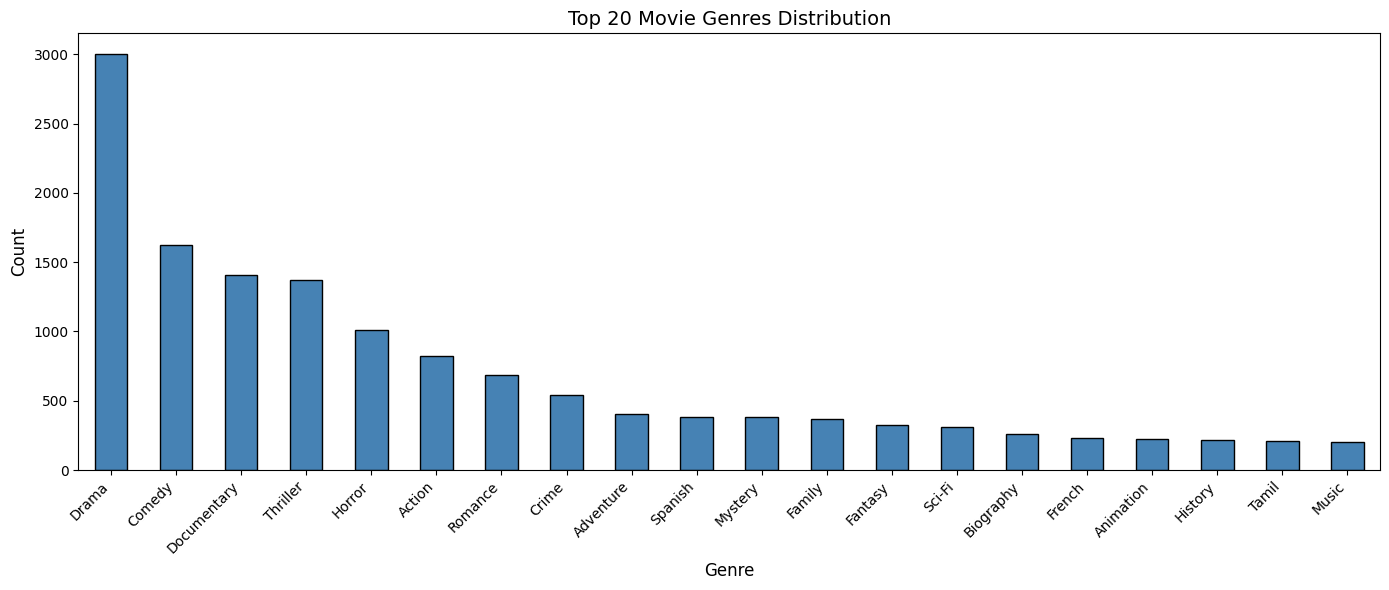

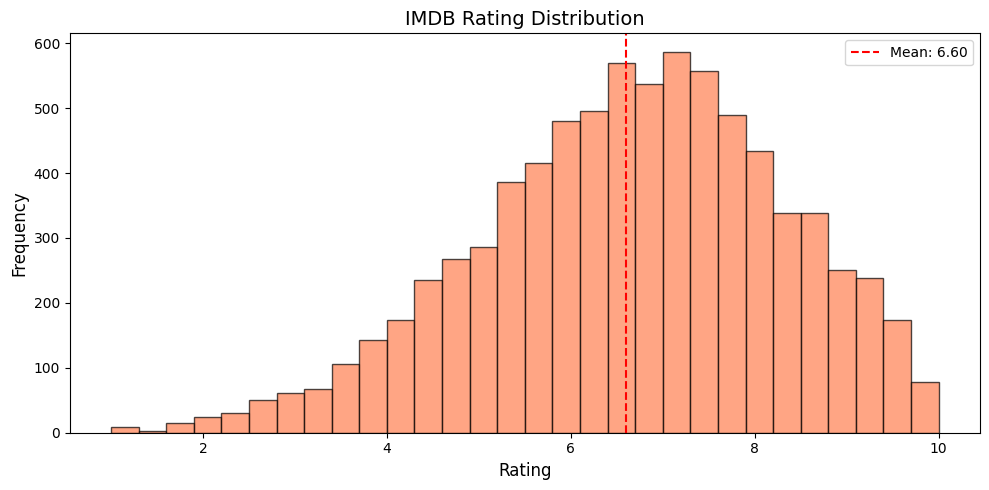

In [3]:
# Analyze genre distribution
all_genres = []
for genres in df['genre'].str.split(', '):
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts()
print(f"Total Unique Genres: {len(genre_counts)}")
print(f"\nTop 20 Genres:\n{genre_counts.head(20)}")

# Visualize genre distribution
plt.figure(figsize=(14, 6))
genre_counts.head(20).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Top 20 Movie Genres Distribution', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Rating distribution
plt.figure(figsize=(10, 5))
plt.hist(df['rating'], bins=30, color='coral', edgecolor='black', alpha=0.7)
plt.title('IMDB Rating Distribution', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['rating'].mean(), color='red', linestyle='--', label=f"Mean: {df['rating'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Data Preprocessing Pipeline

This section implements the complete feature construction pipeline:
1. **Genre Encoding**: Multi-hot encoding of genres
2. **Description Embeddings**: TF-IDF vectorization + dimensionality reduction to 100D
3. **Rating Normalization**: Scale ratings to [0, 1]
4. **Feature Fusion**: Combine all features into a single vector per movie

In [4]:
class MovieFeatureProcessor:
    
    def __init__(self, embedding_dim: int = 100, n_tfidf_features: int = 5000):
        self.embedding_dim = embedding_dim
        self.n_tfidf_features = n_tfidf_features
        
        # Processors
        self.mlb = MultiLabelBinarizer()
        self.tfidf = TfidfVectorizer(max_features=n_tfidf_features, stop_words='english')
        self.svd = TruncatedSVD(n_components=embedding_dim, random_state=SEED)
        self.rating_scaler = MinMaxScaler()
        
        # Metadata
        self.genre_dim = None
        self.feature_dim = None
        self.genre_list = None
        
    def fit(self, df: pd.DataFrame) -> 'MovieFeatureProcessor':
        
        # Process genres
        genres_split = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])
        self.mlb.fit(genres_split)
        self.genre_list = list(self.mlb.classes_)
        self.genre_dim = len(self.genre_list)
        
        # Process descriptions using TF-IDF
        self.tfidf.fit(df['description'].fillna(''))
        tfidf_matrix = self.tfidf.transform(df['description'].fillna(''))
        self.svd.fit(tfidf_matrix)
        
        # Fit rating scaler
        self.rating_scaler.fit(df[['rating']])
        
        # Calculate total feature dimension
        self.feature_dim = self.genre_dim + self.embedding_dim + 1  # genres + embeddings + rating
        
        print(f"Feature Processor Fitted:")
        print(f"  - Genre Dimensions: {self.genre_dim}")
        print(f"  - Embedding Dimensions: {self.embedding_dim}")
        print(f"  - Total Feature Dimensions: {self.feature_dim}")
        
        return self
    
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        
        # Genre multi-hot encoding
        genres_split = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])
        genre_features = self.mlb.transform(genres_split)
        
        # Description embeddings
        tfidf_matrix = self.tfidf.transform(df['description'].fillna(''))
        desc_embeddings = self.svd.transform(tfidf_matrix)
        
        # Normalized ratings
        rating_features = self.rating_scaler.transform(df[['rating']])
        
        # Concatenate all features
        features = np.hstack([genre_features, desc_embeddings, rating_features])
        
        return features.astype(np.float32)
    
    def fit_transform(self, df: pd.DataFrame) -> np.ndarray:
        
        self.fit(df)
        return self.transform(df)
    
    def get_genre_vector(self, genres: List[str]) -> np.ndarray:
        
        return self.mlb.transform([genres])[0]
    
    def save(self, filepath: str):
        
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"Processor saved to {filepath}")
    
    @staticmethod
    def load(filepath: str) -> 'MovieFeatureProcessor':
        """Load processor from disk."""
        with open(filepath, 'rb') as f:
            return pickle.load(f)

In [5]:
# Initialize and fit the feature processor
processor = MovieFeatureProcessor(embedding_dim=100, n_tfidf_features=5000)
movie_features = processor.fit_transform(df)

# Create movie catalog
movie_catalog = {
    'names': df['movie_name'].tolist(),
    'genres': df['genre'].tolist(),
    'ratings': df['rating'].tolist(),
    'descriptions': df['description'].tolist(),
    'features': movie_features
}

print(f"\nMovie Feature Matrix Shape: {movie_features.shape}")
print(f"Feature Vector Sample (first movie):\n{movie_features[0][:20]}...")  # Show first 20 dims

# Verify feature statistics
print(f"\nFeature Statistics:")
print(f"  Min: {movie_features.min():.4f}")
print(f"  Max: {movie_features.max():.4f}")
print(f"  Mean: {movie_features.mean():.4f}")
print(f"  Std: {movie_features.std():.4f}")

Feature Processor Fitted:
  - Genre Dimensions: 209
  - Embedding Dimensions: 100
  - Total Feature Dimensions: 310

Movie Feature Matrix Shape: (7840, 310)
Feature Vector Sample (first movie):
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...

Feature Statistics:
  Min: -0.3169
  Max: 1.0000
  Mean: 0.0100
  Std: 0.0973


## 3. Reinforcement Learning Environment

Implementation of the movie recommendation environment following OpenAI Gym conventions.

**Key Components:**
- **State**: User preference profile (dynamically updated based on interactions)
- **Action**: Movie selection from catalog
- **Reward**: Feedback signal based on user response
- **Episode**: Complete user session with multiple recommendations

In [6]:
# Reward mapping for different feedback types
FEEDBACK_REWARDS = {
    'like': 1.5,       # Strong positive signal
    'watch': 0.8,      # User watched the movie
    'click': 0.4,      # User showed interest
    'skip': -0.2,      # User skipped
    'ignore': -0.5     # User ignored completely
}

class SimulatedUser:
    def __init__(self, feature_dim: int, preference_strength: float = 0.7):
      
        self.feature_dim = feature_dim
        self.preference_strength = preference_strength
        
        # Initialize random preference vector (normalized)
        self.preference_vector = np.random.randn(feature_dim).astype(np.float32)
        self.preference_vector = self.preference_vector / (np.linalg.norm(self.preference_vector) + 1e-8)
        
        # Track interaction history
        self.interaction_history = []
        
    def reset(self):
        
        self.preference_vector = np.random.randn(self.feature_dim).astype(np.float32)
        self.preference_vector = self.preference_vector / (np.linalg.norm(self.preference_vector) + 1e-8)
        self.interaction_history = []
        
    def get_feedback(self, movie_features: np.ndarray) -> Tuple[str, float]:
        
        # Calculate cosine similarity
        similarity = np.dot(self.preference_vector, movie_features) / (
            np.linalg.norm(self.preference_vector) * np.linalg.norm(movie_features) + 1e-8
        )
        
        # Add some randomness to make it more realistic
        noise = np.random.normal(0, 0.1)
        score = similarity * self.preference_strength + noise
        
        # Map score to feedback type
        if score > 0.3:
            feedback = 'like'
        elif score > 0.15:
            feedback = 'watch'
        elif score > 0.0:
            feedback = 'click'
        elif score > -0.15:
            feedback = 'skip'
        else:
            feedback = 'ignore'
            
        reward = FEEDBACK_REWARDS[feedback]
        self.interaction_history.append((movie_features, feedback, reward))
        
        return feedback, reward

In [7]:
class MovieRecommendationEnv:
    
    def __init__(
        self,
        movie_features: np.ndarray,
        movie_names: List[str],
        movie_genres: List[str],
        episode_length: int = 10,
        user_profile_update_rate: float = 0.3,
        mode: str = 'simulated'  # 'simulated' or 'human'
    ):
      
        self.movie_features = movie_features
        self.movie_names = movie_names
        self.movie_genres = movie_genres
        self.n_movies = len(movie_names)
        self.feature_dim = movie_features.shape[1]
        self.episode_length = episode_length
        self.update_rate = user_profile_update_rate
        self.mode = mode
        
        # State and action spaces
        self.state_dim = self.feature_dim
        self.action_dim = self.n_movies
        
        # Environment state
        self.user_state = None
        self.simulated_user = None
        self.step_count = 0
        self.recommended_movies = set()
        self.episode_rewards = []
        
        print(f"Environment Initialized:")
        print(f"  - Movies: {self.n_movies}")
        print(f"  - State Dimension: {self.state_dim}")
        print(f"  - Action Space: {self.action_dim}")
        print(f"  - Episode Length: {self.episode_length}")
        print(f"  - Mode: {self.mode}")
        
    def reset(self) -> np.ndarray:
        
        # Initialize random user state (cold start)
        self.user_state = np.random.randn(self.feature_dim).astype(np.float32) * 0.1
        
        # Reset simulated user
        if self.mode == 'simulated':
            self.simulated_user = SimulatedUser(self.feature_dim)
            
        self.step_count = 0
        self.recommended_movies = set()
        self.episode_rewards = []
        
        return self.user_state.copy()
    
    def step(self, action: int, human_feedback: str = None) -> Tuple[np.ndarray, float, bool, Dict]:
       
        # Validate action
        if action < 0 or action >= self.n_movies:
            raise ValueError(f"Invalid action {action}. Must be in [0, {self.n_movies})")
            
        self.step_count += 1
        movie_features = self.movie_features[action]
        movie_name = self.movie_names[action]
        movie_genre = self.movie_genres[action]
        
        # Get feedback
        if self.mode == 'simulated':
            feedback, reward = self.simulated_user.get_feedback(movie_features)
        else:  # human mode
            if human_feedback is None:
                raise ValueError("Human feedback required in human mode")
            feedback = human_feedback
            reward = FEEDBACK_REWARDS.get(feedback, 0.0)
            
        # Penalize re-recommendations
        if action in self.recommended_movies:
            reward -= 0.3
        self.recommended_movies.add(action)
        
        # Update user state based on feedback
        if reward > 0:
            # Move user profile towards liked movies
            self.user_state = (1 - self.update_rate) * self.user_state + self.update_rate * movie_features
        else:
            # Move user profile away from disliked movies
            self.user_state = (1 + self.update_rate * 0.5) * self.user_state - self.update_rate * 0.5 * movie_features
            
        # Normalize user state
        norm = np.linalg.norm(self.user_state)
        if norm > 0:
            self.user_state = self.user_state / norm
            
        self.episode_rewards.append(reward)
        
        # Check if episode is done
        done = self.step_count >= self.episode_length
        
        info = {
            'movie_name': movie_name,
            'movie_genre': movie_genre,
            'feedback': feedback,
            'step': self.step_count,
            'cumulative_reward': sum(self.episode_rewards)
        }
        
        return self.user_state.copy(), reward, done, info
    
    def get_valid_actions(self) -> List[int]:
        """Get list of movies not yet recommended in this episode."""
        return [i for i in range(self.n_movies) if i not in self.recommended_movies]
    
    def render(self, action: int, reward: float, info: Dict):
        """Print current recommendation status."""
        print(f"\nStep {info['step']}/{self.episode_length}")
        print(f"  Recommended: {info['movie_name']}")
        print(f"  Genre: {info['movie_genre'][:50]}...")
        print(f"  Feedback: {info['feedback']} | Reward: {reward:.2f}")
        print(f"  Cumulative Reward: {info['cumulative_reward']:.2f}")

In [8]:
# Initialize the environment
env = MovieRecommendationEnv(
    movie_features=movie_features,
    movie_names=movie_catalog['names'],
    movie_genres=movie_catalog['genres'],
    episode_length=10,
    user_profile_update_rate=0.3,
    mode='simulated'
)

# Test environment with random actions
print("\n" + "=" * 60)
print("ENVIRONMENT TEST (Random Agent)")
print("=" * 60)

state = env.reset()
total_reward = 0

for step in range(5):
    action = np.random.randint(0, env.n_movies)
    next_state, reward, done, info = env.step(action)
    env.render(action, reward, info)
    total_reward += reward
    state = next_state

print(f"\nTest Complete | Total Reward: {total_reward:.2f}")

Environment Initialized:
  - Movies: 7840
  - State Dimension: 310
  - Action Space: 7840
  - Episode Length: 10
  - Mode: simulated

ENVIRONMENT TEST (Random Agent)

Step 1/10
  Recommended: G-Dragon in Cinema: Übermensch
  Genre: Korean, Documentary, Music...
  Feedback: watch | Reward: 0.80
  Cumulative Reward: 0.80

Step 2/10
  Recommended: Zycie dla poczatkujacych
  Genre: Dark Comedy, Comedy, Horror...
  Feedback: click | Reward: 0.40
  Cumulative Reward: 1.20

Step 3/10
  Recommended: Papyrus
  Genre: Adventure, Animation, Family, Musical...
  Feedback: watch | Reward: 0.80
  Cumulative Reward: 2.00

Step 4/10
  Recommended: Deadly Neighbor
  Genre: Thriller...
  Feedback: skip | Reward: -0.20
  Cumulative Reward: 1.80

Step 5/10
  Recommended: Fuck the Polis
  Genre: Portuguese, Drama...
  Feedback: click | Reward: 0.40
  Cumulative Reward: 2.20

Test Complete | Total Reward: 2.20


## 4. Deep Q-Network (DQN) Agent

Implementation of the DQN agent with:
- **Experience Replay Buffer**: Stores transitions for batch learning
- **Target Network**: Stabilizes training by providing fixed Q-value targets
- **ε-greedy Exploration**: Balances exploration and exploitation
- **Dueling Architecture**: Separate value and advantage streams

In [13]:
class ReplayBuffer:
    
    def __init__(self, capacity: int = 100000):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        """Add transition to buffer."""
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size: int) -> Tuple:
        """Sample random batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )
    
    def __len__(self):
        return len(self.buffer)


class PrioritizedReplayBuffer:
    
    def __init__(self, capacity: int = 100000, alpha: float = 0.6):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.buffer = []
        self.priorities = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done, priority=1.0):
        """Add transition with priority."""
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(priority ** self.alpha)
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = priority ** self.alpha
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size: int, beta: float = 0.4) -> Tuple:
        """Sample batch based on priorities."""
        priorities = np.array(self.priorities)
        probs = priorities / priorities.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        
        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights = weights / weights.max()
        
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
            indices,
            np.array(weights, dtype=np.float32)
        )
    
    def update_priorities(self, indices, priorities):
        """Update priorities after learning."""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = (priority + 1e-6) ** self.alpha
            
    def __len__(self):
        return len(self.buffer)

In [12]:
def build_dqn_model(state_dim: int, action_dim: int, hidden_layers: List[int] = [512, 256, 128]) -> keras.Model:
    # Input layer
    state_input = layers.Input(shape=(state_dim,), name='state_input')
    
    # Shared feature extraction layers
    x = state_input
    for i, units in enumerate(hidden_layers[:-1]):
        x = layers.Dense(units, activation=layers.LeakyReLU(alpha=0.01), name=f'shared_dense_{i}')(x)
        x = layers.BatchNormalization(name=f'bn_{i}')(x)
        x = layers.Dropout(0.2, name=f'dropout_{i}')(x)
    
    # Dueling architecture: separate value and advantage streams
    # Value stream
    value = layers.Dense(hidden_layers[-1],activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='value_dense')(x)
    value = layers.Dense(1, name='value_output')(value)
    
    # Advantage stream
    advantage = layers.Dense(hidden_layers[-1],activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='advantage_dense')(x)
    advantage = layers.Dense(action_dim, name='advantage_output')(advantage)
    
    # Combine value and advantage: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
    q_values = layers.Lambda(
        lambda x: x[0] + (x[1] - tf.reduce_mean(x[1], axis=1, keepdims=True)),
        name='q_values'
    )([value, advantage])
    
    model = keras.Model(inputs=state_input, outputs=q_values, name='DQN')
    return model


def build_simple_dqn_model(state_dim: int, action_dim: int) -> keras.Model:
    """Build a simpler DQN for faster training with LeakyReLU."""
    model = keras.Sequential([
        layers.Input(shape=(state_dim,)),
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dense(action_dim, activation='linear')
    ], name='SimpleDQN')
    return model

In [10]:
class DQNAgent:

    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        learning_rate: float = 0.001,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.995,
        buffer_size: int = 100000,
        batch_size: int = 64,
        target_update_freq: int = 100,
        use_dueling: bool = True
    ):
       
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.learning_rate = learning_rate
        
        # Build networks
        if use_dueling:
            self.q_network = build_dqn_model(state_dim, action_dim)
            self.target_network = build_dqn_model(state_dim, action_dim)
        else:
            self.q_network = build_simple_dqn_model(state_dim, action_dim)
            self.target_network = build_simple_dqn_model(state_dim, action_dim)
            
        # Compile Q-network
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)
        self.q_network.compile(optimizer=self.optimizer, loss='mse')
        
        # Copy weights to target network
        self.update_target_network()
        
        # Experience replay buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_size)
        
        # Training statistics
        self.train_step = 0
        self.loss_history = []
        
        print(f"\nDQN Agent Initialized:")
        print(f"  - State Dim: {state_dim}")
        print(f"  - Action Dim: {action_dim}")
        print(f"  - Dueling: {use_dueling}")
        print(f"  - Learning Rate: {learning_rate}")
        print(f"  - Gamma: {gamma}")
        print(f"  - Epsilon: {epsilon_start} → {epsilon_end}")
        
    def update_target_network(self):
        """Copy weights from Q-network to target network."""
        self.target_network.set_weights(self.q_network.get_weights())
        
    def select_action(self, state: np.ndarray, valid_actions: List[int] = None, training: bool = True) -> int:
  
        if valid_actions is None:
            valid_actions = list(range(self.action_dim))
            
        # Exploration: random action
        if training and np.random.random() < self.epsilon:
            return np.random.choice(valid_actions)
        
        # Exploitation: best action from Q-network
        state_tensor = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state_tensor, verbose=0)[0]
        
        # Mask invalid actions
        masked_q = np.full(self.action_dim, -np.inf)
        masked_q[valid_actions] = q_values[valid_actions]
        
        return int(np.argmax(masked_q))
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.push(state, action, reward, next_state, done)
        
    def train(self) -> float:
        """
        Train the agent on a batch from replay buffer.
        
        Returns:
            Training loss
        """
        if len(self.replay_buffer) < self.batch_size:
            return 0.0
            
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Compute target Q-values
        next_q_values = self.target_network.predict(next_states, verbose=0)
        max_next_q = np.max(next_q_values, axis=1)
        targets = rewards + self.gamma * max_next_q * (1 - dones)
        
        # Get current Q-values and update only for taken actions
        current_q = self.q_network.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_q[i, action] = targets[i]
            
        
        # Train Q-network
        loss = self.q_network.train_on_batch(states, current_q)
        self.loss_history.append(loss)
        
        # Update target network periodically
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()
            
        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        return loss
    
    def save(self, filepath: str):
      
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
        self.q_network.save(f"{filepath}_q_network.keras")
        self.target_network.save(f"{filepath}_target_network.keras")
        
        # Save hyperparameters
        params = {
            'state_dim': self.state_dim,
            'action_dim': self.action_dim,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'epsilon_end': self.epsilon_end,
            'epsilon_decay': self.epsilon_decay,
            'batch_size': self.batch_size,
            'target_update_freq': self.target_update_freq,
            'learning_rate': self.learning_rate
        }
        with open(f"{filepath}_params.pkl", 'wb') as f:
            pickle.dump(params, f)
            
        print(f"Agent saved to {filepath}")
        
    @classmethod
    def load(cls, filepath: str) -> 'DQNAgent':
        """Load agent from disk."""
        with open(f"{filepath}_params.pkl", 'rb') as f:
            params = pickle.load(f)
            
        agent = cls(
            state_dim=params['state_dim'],
            action_dim=params['action_dim'],
            gamma=params['gamma'],
            epsilon_start=params['epsilon'],
            epsilon_end=params['epsilon_end'],
            epsilon_decay=params['epsilon_decay'],
            batch_size=params['batch_size'],
            target_update_freq=params['target_update_freq'],
            learning_rate=params['learning_rate'],
            use_dueling=False  # Will load weights anyway
        )
        
        agent.q_network = keras.models.load_model(f"{filepath}_q_network.keras")
        agent.target_network = keras.models.load_model(f"{filepath}_target_network.keras")
        
        print(f"Agent loaded from {filepath}")
        return agent

In [14]:
# Initialize the DQN Agent
agent = DQNAgent(
    state_dim=env.state_dim,
    action_dim=env.action_dim,
    learning_rate=0.001,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.998,
    buffer_size=50000,
    batch_size=64,
    target_update_freq=50,
    use_dueling=True
)

# Display model architecture
agent.q_network.summary()


DQN Agent Initialized:
  - State Dim: 310
  - Action Dim: 7840
  - Dueling: True
  - Learning Rate: 0.001
  - Gamma: 0.95
  - Epsilon: 1.0 → 0.05
Model: "DQN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 state_input (InputLayer)       [(None, 310)]        0           []                               
                                                                                                  
 shared_dense_0 (Dense)         (None, 512)          159232      ['state_input[0][0]']            
                                                                                                  
 bn_0 (BatchNormalization)      (None, 512)          2048        ['shared_dense_0[0][0]']         
                                                                                                  
 dropout_0 (Dropout)            (None, 512)     

## 5. Training Pipeline

Train the DQN agent using the simulated user environment. The training loop includes:
- Episode-based interaction
- Experience collection and replay
- Periodic evaluation and logging

In [16]:
def train_agent(
    agent: DQNAgent,
    env: MovieRecommendationEnv,
    n_episodes: int = 500,
    eval_freq: int = 50,
    verbose: bool = True
) -> Dict:
    """
    Train the DQN agent.
    
    Args:
        agent: DQN agent to train
        env: Recommendation environment
        n_episodes: Number of training episodes
        eval_freq: Frequency of evaluation logging
        verbose: Whether to print progress
        
    Returns:
        Dictionary containing training history
    """
    history = {
        'episode_rewards': [],
        'episode_lengths': [],
        'avg_rewards': [],
        'epsilon_values': [],
        'losses': []
    }
    
    best_avg_reward = float('-inf')
    
    print("=" * 60)
    print("TRAINING STARTED")
    print("=" * 60)
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = []
        
        for step in range(env.episode_length):
            # Select action
            valid_actions = env.get_valid_actions()
            action = agent.select_action(state, valid_actions, training=True)
             
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            # Train agent
            loss = agent.train()
            if loss > 0:
                episode_loss.append(loss)
                
            episode_reward += reward
            state = next_state
            
            if done:
                break
                
        # Record history
        history['episode_rewards'].append(episode_reward)
        history['episode_lengths'].append(step + 1)
        history['epsilon_values'].append(agent.epsilon)
        if episode_loss:
            history['losses'].append(np.mean(episode_loss))
            
        # Calculate running average
        window = min(50, len(history['episode_rewards']))
        avg_reward = np.mean(history['episode_rewards'][-window:])
        history['avg_rewards'].append(avg_reward)
        
        # Track best model
        if avg_reward > best_avg_reward and episode > 50:
            best_avg_reward = avg_reward
            
        # Logging
        if verbose and (episode + 1) % eval_freq == 0:
            print(f"Episode {episode + 1:4d}/{n_episodes} | "
                  f"Reward: {episode_reward:6.2f} | "
                  f"Avg Reward: {avg_reward:6.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Buffer: {len(agent.replay_buffer):5d}")
    
    print("=" * 60)
    print(f"TRAINING COMPLETED")
    print(f"Best Average Reward: {best_avg_reward:.2f}")
    print("=" * 60)
    
    return history

In [17]:
# Train the agent
training_history = train_agent(
    agent=agent,
    env=env,
    n_episodes=300,  # Adjust based on computational resources
    eval_freq=25,
    verbose=True
)

TRAINING STARTED
Episode   25/300 | Reward:  -0.20 | Avg Reward:   1.48 | Epsilon: 0.688 | Buffer:   250
Episode   50/300 | Reward:  -2.00 | Avg Reward:   1.12 | Epsilon: 0.417 | Buffer:   500
Episode   75/300 | Reward:   1.30 | Avg Reward:   0.77 | Epsilon: 0.253 | Buffer:   750
Episode  100/300 | Reward:  -0.20 | Avg Reward:   0.89 | Epsilon: 0.153 | Buffer:  1000
Episode  125/300 | Reward:  -0.20 | Avg Reward:   1.11 | Epsilon: 0.093 | Buffer:  1250
Episode  150/300 | Reward:   1.20 | Avg Reward:   1.06 | Epsilon: 0.056 | Buffer:  1500
Episode  175/300 | Reward:   3.20 | Avg Reward:   1.24 | Epsilon: 0.050 | Buffer:  1750
Episode  200/300 | Reward:   1.40 | Avg Reward:   1.25 | Epsilon: 0.050 | Buffer:  2000
Episode  225/300 | Reward:   0.50 | Avg Reward:   0.94 | Epsilon: 0.050 | Buffer:  2250
Episode  250/300 | Reward:   1.40 | Avg Reward:   1.01 | Epsilon: 0.050 | Buffer:  2500
Episode  275/300 | Reward:   3.20 | Avg Reward:   1.35 | Epsilon: 0.050 | Buffer:  2750
Episode  300/30

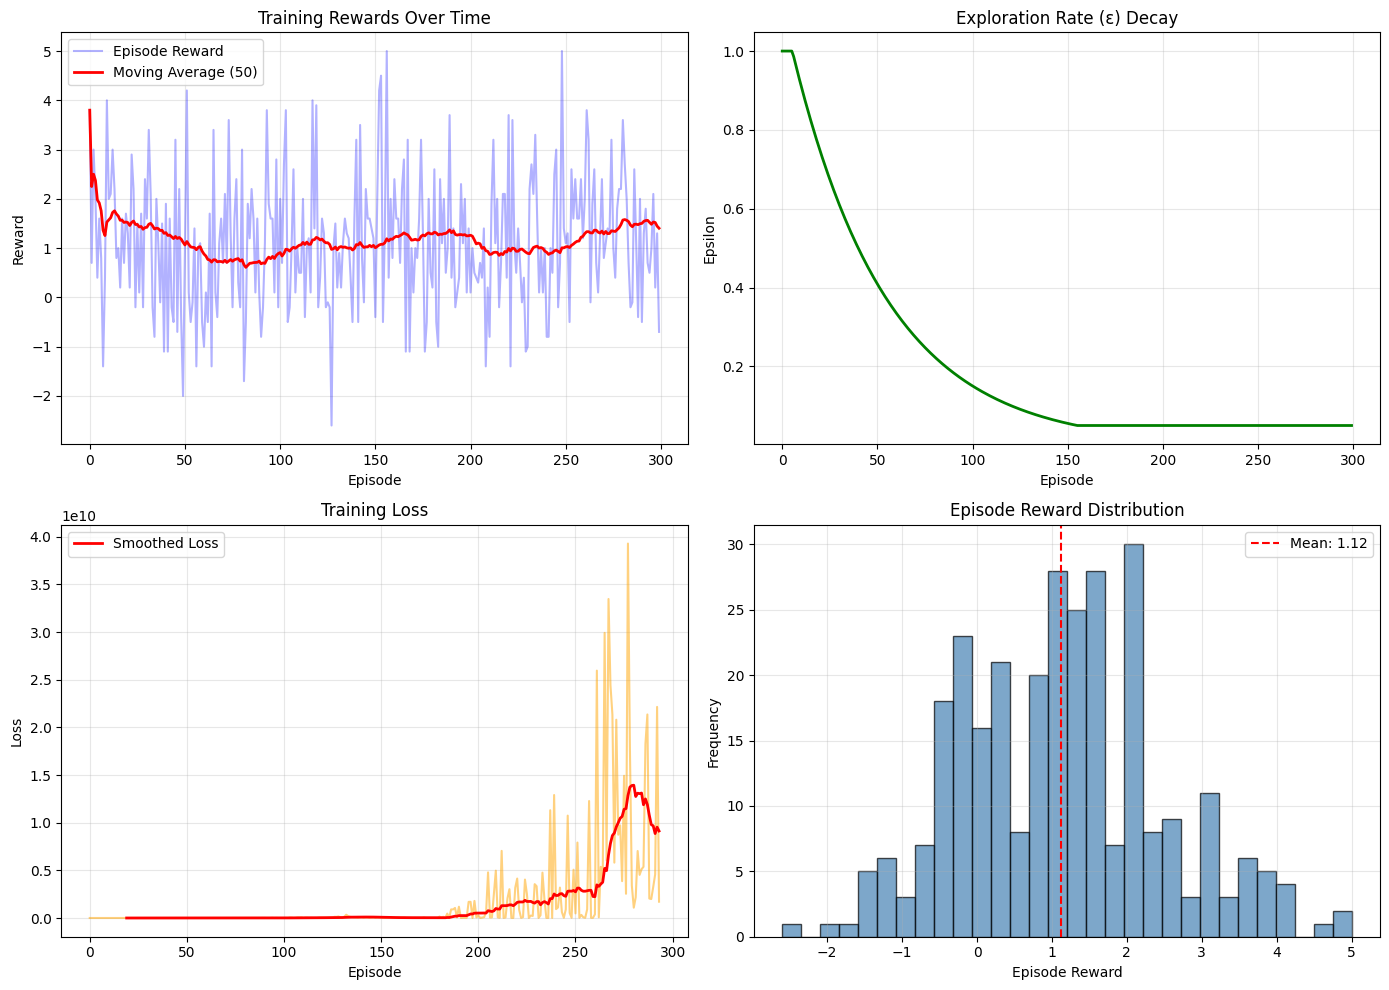


Training Statistics:
  Final Average Reward: 1.40
  Max Episode Reward: 5.00
  Final Epsilon: 0.0500


In [18]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode Rewards
ax1 = axes[0, 0]
ax1.plot(training_history['episode_rewards'], alpha=0.3, color='blue', label='Episode Reward')
ax1.plot(training_history['avg_rewards'], color='red', linewidth=2, label='Moving Average (50)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Training Rewards Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Epsilon Decay
ax2 = axes[0, 1]
ax2.plot(training_history['epsilon_values'], color='green', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.set_title('Exploration Rate (ε) Decay')
ax2.grid(True, alpha=0.3)

# Training Loss
ax3 = axes[1, 0]
if training_history['losses']:
    ax3.plot(training_history['losses'], alpha=0.5, color='orange')
    # Smooth loss
    window = min(20, len(training_history['losses']))
    if window > 1:
        smooth_loss = pd.Series(training_history['losses']).rolling(window=window).mean()
        ax3.plot(smooth_loss, color='red', linewidth=2, label='Smoothed Loss')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.set_title('Training Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Reward Distribution
ax4 = axes[1, 1]
ax4.hist(training_history['episode_rewards'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax4.axvline(np.mean(training_history['episode_rewards']), color='red', linestyle='--', 
            label=f"Mean: {np.mean(training_history['episode_rewards']):.2f}")
ax4.set_xlabel('Episode Reward')
ax4.set_ylabel('Frequency')
ax4.set_title('Episode Reward Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining Statistics:")
print(f"  Final Average Reward: {training_history['avg_rewards'][-1]:.2f}")
print(f"  Max Episode Reward: {max(training_history['episode_rewards']):.2f}")
print(f"  Final Epsilon: {training_history['epsilon_values'][-1]:.4f}")

## 6. Evaluation Metrics

Comprehensive offline evaluation using:
1. **Cumulative Reward**: Average reward per episode
2. **Precision@K**: Proportion of relevant items in top-K recommendations
3. **NDCG@K**: Normalized Discounted Cumulative Gain
4. **Diversity Metrics**: Genre coverage and intra-list diversity

In [19]:
class RecommendationEvaluator:
    """
    Comprehensive evaluation suite for the recommendation system.
    """
    
    def __init__(self, movie_features: np.ndarray, movie_genres: List[str]):
        self.movie_features = movie_features
        self.movie_genres = movie_genres
        self.n_movies = len(movie_genres)
        
        # Parse genres for diversity calculation
        self.genre_sets = [set(g.strip() for g in genre.split(',')) for genre in movie_genres]
        self.all_genres = set()
        for gs in self.genre_sets:
            self.all_genres.update(gs)
            
    def precision_at_k(self, recommended_items: List[int], relevant_items: List[int], k: int) -> float:
        """
        Calculate Precision@K.
        
        Args:
            recommended_items: List of recommended item indices
            relevant_items: List of relevant item indices (ground truth)
            k: Number of top items to consider
        """
        if k == 0:
            return 0.0
        recommended_k = recommended_items[:k]
        relevant_set = set(relevant_items)
        hits = sum(1 for item in recommended_k if item in relevant_set)
        return hits / k
    
    def dcg_at_k(self, relevances: List[float], k: int) -> float:
        """Calculate DCG@K."""
        relevances = np.array(relevances)[:k]
        if len(relevances) == 0:
            return 0.0
        discounts = np.log2(np.arange(2, len(relevances) + 2))
        return np.sum(relevances / discounts)
    
    def ndcg_at_k(self, recommended_items: List[int], relevance_scores: Dict[int, float], k: int) -> float:
        """
        Calculate NDCG@K.
        
        Args:
            recommended_items: List of recommended item indices
            relevance_scores: Dictionary mapping item index to relevance score
            k: Number of top items to consider
        """
        # Get relevances for recommended items
        relevances = [relevance_scores.get(item, 0.0) for item in recommended_items[:k]]
        dcg = self.dcg_at_k(relevances, k)
        
        # Ideal DCG
        ideal_relevances = sorted(relevance_scores.values(), reverse=True)[:k]
        idcg = self.dcg_at_k(ideal_relevances, k)
        
        if idcg == 0:
            return 0.0
        return dcg / idcg
    
    def genre_coverage(self, recommended_items: List[int]) -> float:
        """Calculate genre coverage (proportion of genres covered)."""
        covered_genres = set()
        for item in recommended_items:
            covered_genres.update(self.genre_sets[item])
        return len(covered_genres) / len(self.all_genres)
    
    def intra_list_diversity(self, recommended_items: List[int]) -> float:
        """
        Calculate intra-list diversity using average pairwise distance.
        """
        if len(recommended_items) < 2:
            return 0.0
            
        features = self.movie_features[recommended_items]
        n = len(recommended_items)
        
        # Calculate pairwise cosine distances
        total_distance = 0
        count = 0
        for i in range(n):
            for j in range(i + 1, n):
                # Cosine distance = 1 - cosine similarity
                sim = np.dot(features[i], features[j]) / (
                    np.linalg.norm(features[i]) * np.linalg.norm(features[j]) + 1e-8
                )
                total_distance += (1 - sim)
                count += 1
                
        return total_distance / count if count > 0 else 0.0
    
    def evaluate_episode(
        self,
        agent: DQNAgent,
        env: MovieRecommendationEnv,
        k_values: List[int] = [5, 10]
    ) -> Dict:
        """
        Run one evaluation episode and compute metrics.
        """
        state = env.reset()
        recommendations = []
        rewards = []
        
        # Simulate user's true preferences for relevance
        true_preferences = env.simulated_user.preference_vector
        
        # Calculate relevance scores based on similarity to user preferences
        relevance_scores = {}
        for i in range(self.n_movies):
            sim = np.dot(true_preferences, self.movie_features[i]) / (
                np.linalg.norm(true_preferences) * np.linalg.norm(self.movie_features[i]) + 1e-8
            )
            relevance_scores[i] = max(0, sim)
            
        # Get "truly relevant" items (top by similarity)
        sorted_items = sorted(relevance_scores.items(), key=lambda x: x[1], reverse=True)
        relevant_items = [item for item, score in sorted_items[:20] if score > 0.1]
        
        # Run episode
        for step in range(env.episode_length):
            valid_actions = env.get_valid_actions()
            action = agent.select_action(state, valid_actions, training=False)
            next_state, reward, done, info = env.step(action)
            
            recommendations.append(action)
            rewards.append(reward)
            state = next_state
            
            if done:
                break
                
        # Compute metrics
        metrics = {
            'cumulative_reward': sum(rewards),
            'avg_reward': np.mean(rewards),
            'genre_coverage': self.genre_coverage(recommendations),
            'diversity': self.intra_list_diversity(recommendations)
        }
        
        for k in k_values:
            metrics[f'precision@{k}'] = self.precision_at_k(recommendations, relevant_items, k)
            metrics[f'ndcg@{k}'] = self.ndcg_at_k(recommendations, relevance_scores, k)
            
        return metrics, recommendations
    
    def evaluate_agent(
        self,
        agent: DQNAgent,
        env: MovieRecommendationEnv,
        n_episodes: int = 100,
        k_values: List[int] = [5, 10]
    ) -> Dict:
        """
        Comprehensive evaluation over multiple episodes.
        """
        all_metrics = []
        
        for _ in range(n_episodes):
            metrics, _ = self.evaluate_episode(agent, env, k_values)
            all_metrics.append(metrics)
            
        # Aggregate metrics
        aggregated = {}
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            aggregated[key] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
            
        return aggregated

In [20]:
# Initialize evaluator and run comprehensive evaluation
evaluator = RecommendationEvaluator(
    movie_features=movie_features,
    movie_genres=movie_catalog['genres']
)

print("=" * 60)
print("COMPREHENSIVE EVALUATION")
print("=" * 60)

# Evaluate trained agent
eval_results = evaluator.evaluate_agent(
    agent=agent,
    env=env,
    n_episodes=100,
    k_values=[3, 5, 100]
)

# Display results
print("\n📊 Evaluation Results (100 episodes):\n")
print("-" * 50)
for metric, stats in eval_results.items():
    print(f"{metric:20s}: {stats['mean']:7.4f} ± {stats['std']:.4f}")
print("-" * 50)

COMPREHENSIVE EVALUATION

📊 Evaluation Results (100 episodes):

--------------------------------------------------
cumulative_reward   :  1.2560 ± 1.2143
avg_reward          :  0.1256 ± 0.1214
genre_coverage      :  0.0695 ± 0.0146
diversity           :  0.7399 ± 0.0319
precision@3         :  0.0033 ± 0.0332
ndcg@3              :  0.1354 ± 0.1101
precision@5         :  0.0020 ± 0.0199
ndcg@5              :  0.1331 ± 0.0898
precision@100       :  0.0002 ± 0.0014
ndcg@100            :  0.0357 ± 0.0203
--------------------------------------------------


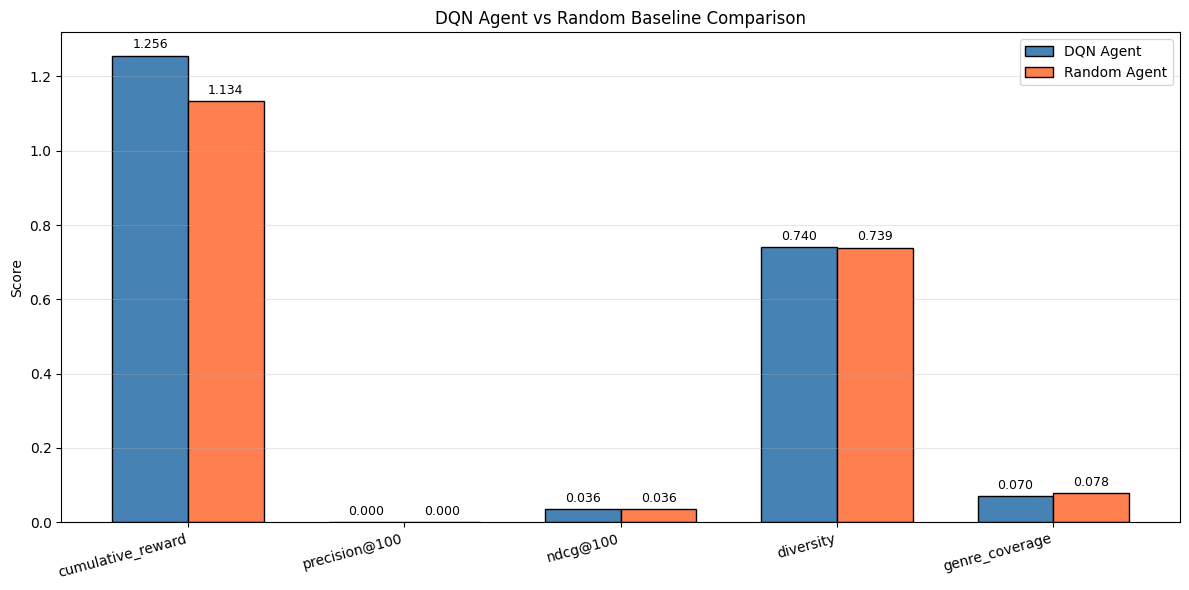


📈 Improvement over Random Baseline:
----------------------------------------
cumulative_reward   : +10.8%
precision@100       : +0.0%
ndcg@100            : -1.9%
diversity           : +0.1%
genre_coverage      : -11.3%


In [21]:
# Compare with Random Agent baseline
class RandomAgent:
    """Baseline random agent for comparison."""
    def __init__(self, action_dim):
        self.action_dim = action_dim

    def select_action(self, state, valid_actions=None, training=False):
        if valid_actions is None:
            valid_actions = list(range(self.action_dim))
        return np.random.choice(valid_actions)

# Evaluate random baseline
random_agent = RandomAgent(env.action_dim)
random_results = evaluator.evaluate_agent(random_agent, env, n_episodes=100, k_values=[3, 5, 100])

# Comparison visualization
metrics_to_compare = ['cumulative_reward', 'precision@100', 'ndcg@100', 'diversity', 'genre_coverage']
dqn_means = [eval_results[m]['mean'] for m in metrics_to_compare]
random_means = [random_results[m]['mean'] for m in metrics_to_compare]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_compare))
width = 0.35

bars1 = ax.bar(x - width/2, dqn_means, width, label='DQN Agent', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, random_means, width, label='Random Agent', color='coral', edgecolor='black')

ax.set_ylabel('Score')
ax.set_title('DQN Agent vs Random Baseline Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_compare, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('agent_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print improvement percentages
print("\n📈 Improvement over Random Baseline:")
print("-" * 40)
for metric in metrics_to_compare:
    dqn_val = eval_results[metric]['mean']
    random_val = random_results[metric]['mean']
    if random_val != 0:
        improvement = ((dqn_val - random_val) / abs(random_val)) * 100
        print(f"{metric:20s}: {improvement:+.1f}%")
    else:
        print(f"{metric:20s}: N/A (random baseline is 0)")

## 7. Human-in-the-Loop Interaction Mode

Interactive mode where users can provide real feedback to recommendations.

In [22]:
class HumanInteractionSession:
    """
    Manages human-in-the-loop interaction sessions.
    """
    
    def __init__(
        self,
        agent: DQNAgent,
        movie_catalog: Dict,
        processor: MovieFeatureProcessor,
        session_length: int = 10
    ):
        self.agent = agent
        self.movie_catalog = movie_catalog
        self.processor = processor
        self.session_length = session_length
        self.n_movies = len(movie_catalog['names'])
        
        # Session state
        self.user_state = None
        self.recommendations = []
        self.feedback_history = []
        self.rewards = []
        
    def start_session(self):
        """Initialize a new interaction session."""
        self.user_state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.1
        self.recommendations = []
        self.feedback_history = []
        self.rewards = []
        
        print("=" * 60)
        print("🎬 MOVIE RECOMMENDATION SESSION STARTED")
        print("=" * 60)
        print("\nFeedback options: like | watch | click | skip | ignore")
        print("Type 'quit' to end the session early.\n")
        
    def get_recommendation(self) -> int:
        """Get next recommendation from the agent."""
        valid_actions = [i for i in range(self.n_movies) 
                        if i not in [r['movie_id'] for r in self.recommendations]]
        
        action = self.agent.select_action(self.user_state, valid_actions, training=False)
        return action
    
    def display_recommendation(self, movie_id: int, step: int):
        """Display movie recommendation to user."""
        print(f"\n{'─' * 50}")
        print(f"📽️  Recommendation {step + 1}/{self.session_length}")
        print(f"{'─' * 50}")
        print(f"🎬 Title: {self.movie_catalog['names'][movie_id]}")
        print(f"🎭 Genre: {self.movie_catalog['genres'][movie_id]}")
        print(f"⭐ Rating: {self.movie_catalog['ratings'][movie_id]:.1f}/10")
        print(f"📝 Description: {self.movie_catalog['descriptions'][movie_id][:200]}...")
        
    def process_feedback(self, movie_id: int, feedback: str):
        """Process user feedback and update state."""
        reward = FEEDBACK_REWARDS.get(feedback, 0.0)
        movie_features = self.movie_catalog['features'][movie_id]
        
        # Update user state
        update_rate = 0.3
        if reward > 0:
            self.user_state = (1 - update_rate) * self.user_state + update_rate * movie_features
        else:
            self.user_state = (1 + update_rate * 0.5) * self.user_state - update_rate * 0.5 * movie_features
            
        # Normalize
        norm = np.linalg.norm(self.user_state)
        if norm > 0:
            self.user_state = self.user_state / norm
        
        # Record
        self.recommendations.append({
            'movie_id': movie_id,
            'movie_name': self.movie_catalog['names'][movie_id],
            'feedback': feedback,
            'reward': reward
        })
        self.feedback_history.append(feedback)
        self.rewards.append(reward)
        
        print(f"\n✅ Feedback recorded: {feedback} (reward: {reward:+.1f})")
        
    def run_interactive_session(self):
        """Run full interactive session with user input."""
        self.start_session()
        
        for step in range(self.session_length):
            movie_id = self.get_recommendation()
            self.display_recommendation(movie_id, step)
            
            # Get user feedback
            while True:
                feedback = input("\n👉 Your feedback (like/watch/click/skip/ignore): ").strip().lower()
                if feedback == 'quit':
                    print("\nSession ended early.")
                    break
                if feedback in FEEDBACK_REWARDS:
                    break
                print("Invalid feedback. Please choose: like, watch, click, skip, or ignore")
                
            if feedback == 'quit':
                break
                
            self.process_feedback(movie_id, feedback)
            
        self.show_session_summary()
        
    def run_demo_session(self, simulated_feedback: List[str] = None):
        """Run demo session with simulated or predefined feedback."""
        self.start_session()
        
        if simulated_feedback is None:
            # Generate random feedback for demo
            simulated_feedback = [random.choice(list(FEEDBACK_REWARDS.keys())) 
                                 for _ in range(self.session_length)]
            
        for step in range(min(self.session_length, len(simulated_feedback))):
            movie_id = self.get_recommendation()
            self.display_recommendation(movie_id, step)
            
            feedback = simulated_feedback[step]
            print(f"\n👉 [Simulated] Feedback: {feedback}")
            self.process_feedback(movie_id, feedback)
            
        self.show_session_summary()
        
    def show_session_summary(self):
        """Display session summary."""
        print("\n" + "=" * 60)
        print("📊 SESSION SUMMARY")
        print("=" * 60)
        
        print(f"\n📈 Total Recommendations: {len(self.recommendations)}")
        print(f"🏆 Total Reward: {sum(self.rewards):.2f}")
        print(f"📊 Average Reward: {np.mean(self.rewards):.2f}")
        
        # Feedback distribution
        print("\n📋 Feedback Distribution:")
        for feedback_type in FEEDBACK_REWARDS.keys():
            count = self.feedback_history.count(feedback_type)
            print(f"   {feedback_type:10s}: {count:2d} ({100*count/len(self.feedback_history):.1f}%)")
            
        print("\n🎬 Recommended Movies:")
        for i, rec in enumerate(self.recommendations, 1):
            emoji = "👍" if rec['reward'] > 0 else "👎" if rec['reward'] < 0 else "😐"
            print(f"   {i:2d}. {emoji} {rec['movie_name'][:40]:40s} | {rec['feedback']}")

In [20]:
session = HumanInteractionSession(
    agent=agent,
    movie_catalog=movie_catalog,
    processor=processor,
    session_length=10
)
session.run_interactive_session()

🎬 MOVIE RECOMMENDATION SESSION STARTED

Feedback options: like | watch | click | skip | ignore
Type 'quit' to end the session early.


──────────────────────────────────────────────────
📽️  Recommendation 1/10
──────────────────────────────────────────────────
🎬 Title: 120 Bahadur
🎭 Genre: Hindi, Action, Drama, History, War
⭐ Rating: 7.1/10
📝 Description: Valiant Indian soldiers fight against Chinese troops during the 1962 Sino-Indian War, preventing a potential occupation of Ladakh region in the Battle of Rezang La....

✅ Feedback recorded: like (reward: +1.0)

──────────────────────────────────────────────────
📽️  Recommendation 2/10
──────────────────────────────────────────────────
🎬 Title: Land with No Rider
🎭 Genre: Documentary
⭐ Rating: 8.7/10
📝 Description: The last cowboys of New Mexico eke out a fragile survival in a shrinking world of isolation, memories and rugged beauty as an epic drought devastates the American West....

✅ Feedback recorded: skip (reward: -0.2)

─────────

## 8. Recommendation Generation

Generate final recommendations for a given user state or new cold-start user.

In [27]:
class MovieRecommender:
    """
    Final recommendation system that uses the trained DQN agent.
    """
    
    def __init__(
        self,
        agent: DQNAgent,
        movie_catalog: Dict,
        processor: MovieFeatureProcessor
    ):
        self.agent = agent
        self.movie_catalog = movie_catalog
        self.processor = processor
        self.n_movies = len(movie_catalog['names'])
        
    def get_top_k_recommendations(
        self,
        user_state: np.ndarray = None,
        k: int = 10,
        excluded_movies: List[int] = None
    ) -> List[Dict]:
        """
        Get top-K movie recommendations for a user.
        
        Args:
            user_state: User preference vector (if None, uses cold-start random state)
            k: Number of recommendations
            excluded_movies: Movie indices to exclude (already watched)
            
        Returns:
            List of recommendation dictionaries
        """
        if user_state is None:
            # Cold-start: random initialization
            user_state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.1
            
        if excluded_movies is None:
            excluded_movies = []
            
        # Get Q-values for all movies
        state_tensor = np.expand_dims(user_state, axis=0)
        q_values = self.agent.q_network.predict(state_tensor, verbose=0)[0]
        
        # Mask excluded movies
        valid_mask = np.ones(self.n_movies, dtype=bool)
        valid_mask[excluded_movies] = False
        
        # Get top-K indices
        masked_q = np.where(valid_mask, q_values, -np.inf)
        top_k_indices = np.argsort(masked_q)[-k:][::-1]
        
        recommendations = []
        for rank, movie_id in enumerate(top_k_indices, 1):
            recommendations.append({
                'rank': rank,
                'movie_id': int(movie_id),
                'movie_name': self.movie_catalog['names'][movie_id],
                'genre': self.movie_catalog['genres'][movie_id],
                'rating': self.movie_catalog['ratings'][movie_id],
                'description': self.movie_catalog['descriptions'][movie_id],
                'q_value': float(q_values[movie_id])
            })
            
        return recommendations
    
    def recommend_by_genre_preference(
        self,
        preferred_genres: List[str],
        k: int = 10
    ) -> List[Dict]:
        """
        Get recommendations based on genre preferences.
        
        Args:
            preferred_genres: List of preferred genres
            k: Number of recommendations
        """
        # Create user state biased towards preferred genres
        genre_vector = self.processor.get_genre_vector(preferred_genres)
        
        # Combine with random embedding and neutral rating
        embedding = np.random.randn(self.processor.embedding_dim).astype(np.float32) * 0.1
        rating = np.array([0.7])  # Slightly above average preference
        
        user_state = np.concatenate([genre_vector, embedding, rating]).astype(np.float32)
        
        # Normalize
        user_state = user_state / (np.linalg.norm(user_state) + 1e-8)
        
        return self.get_top_k_recommendations(user_state, k)
    
    def display_recommendations(self, recommendations: List[Dict]):
        """Pretty print recommendations."""
        print("\n" + "=" * 70)
        print("🎬 TOP MOVIE RECOMMENDATIONS")
        print("=" * 70)
        
        for rec in recommendations:
            print(f"\n#{rec['rank']:2d} | Q-value: {rec['q_value']:.4f}")
            print(f"    📽️  {rec['movie_name']}")
            print(f"    🎭  {rec['genre'][:60]}...")
            print(f"    ⭐  IMDB: {rec['rating']:.1f}/10")
            print(f"    📝  {rec['description'][:100]}...")

In [28]:
# Initialize the recommender
recommender = MovieRecommender(
    agent=agent,
    movie_catalog=movie_catalog,
    processor=processor
)

# Example 1: Cold-start recommendations (new user)
print("📌 COLD-START RECOMMENDATIONS (New User)")
cold_start_recs = recommender.get_top_k_recommendations(k=10)
recommender.display_recommendations(cold_start_recs)

📌 COLD-START RECOMMENDATIONS (New User)

🎬 TOP MOVIE RECOMMENDATIONS

# 1 | Q-value: 29.5213
    📽️  Parasomnia
    🎭  Horror...
    ⭐  IMDB: 7.8/10
    📝  After her friend vanishes, Riley must confront the demon from her night terrors that may have crosse...

# 2 | Q-value: 29.4407
    📽️  Universal
    🎭  Comedy, Drama, Sci-Fi...
    ⭐  IMDB: 7.5/10
    📝  A couple of academics enjoying a romantic break in a remote log cabin find their stay interrupted by...

# 3 | Q-value: 29.4398
    📽️  L'arbre de l'authenticité
    🎭  French...
    ⭐  IMDB: 6.4/10
    📝  A film essay exploring the Democratic Republic of Congo's colonial history and its ecological signif...

# 4 | Q-value: 29.4284
    📽️  Trapped in Temptation
    🎭  Thriller...
    ⭐  IMDB: 7.5/10
    📝  In a tale of love, betrayal, and forbidden desires, a devoted wife grapples with loneliness and her ...

# 5 | Q-value: 29.4176
    📽️  Thalli Manasu
    🎭  Telugu, Drama, Family...
    ⭐  IMDB: 6.3/10
    📝  Jyothi, a widow who 

## 9. Model Persistence

Save the trained model and all components for later use.

In [29]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save the trained agent
agent.save('models/dqn_recommender')

# Save the feature processor
processor.save('models/feature_processor.pkl')

# Save training history
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(training_history, f)

# Save movie catalog (for inference)
with open('models/movie_catalog.pkl', 'wb') as f:
    pickle.dump(movie_catalog, f)

print("\n✅ All models and artifacts saved to 'models/' directory")
print("   - dqn_recommender_q_network.keras")
print("   - dqn_recommender_target_network.keras")
print("   - dqn_recommender_params.pkl")
print("   - feature_processor.pkl")
print("   - training_history.pkl")
print("   - movie_catalog.pkl")

Agent saved to models/dqn_recommender
Processor saved to models/feature_processor.pkl

✅ All models and artifacts saved to 'models/' directory
   - dqn_recommender_q_network.keras
   - dqn_recommender_target_network.keras
   - dqn_recommender_params.pkl
   - feature_processor.pkl
   - training_history.pkl
   - movie_catalog.pkl


In [30]:
# Demonstrate loading the saved model
print("=" * 60)
print("LOADING SAVED MODEL")
print("=" * 60)

# Load components
loaded_agent = DQNAgent.load('models/dqn_recommender')
loaded_processor = MovieFeatureProcessor.load('models/feature_processor.pkl')

with open('models/movie_catalog.pkl', 'rb') as f:
    loaded_catalog = pickle.load(f)

# Create recommender with loaded components
loaded_recommender = MovieRecommender(
    agent=loaded_agent,
    movie_catalog=loaded_catalog,
    processor=loaded_processor
)

# Verify it works
print("\n📌 RECOMMENDATIONS FROM LOADED MODEL:")
loaded_recs = loaded_recommender.get_top_k_recommendations(k=5)
loaded_recommender.display_recommendations(loaded_recs)

LOADING SAVED MODEL

DQN Agent Initialized:
  - State Dim: 310
  - Action Dim: 7840
  - Dueling: False
  - Learning Rate: 0.001
  - Gamma: 0.95
  - Epsilon: 0.05 → 0.05
Agent loaded from models/dqn_recommender

📌 RECOMMENDATIONS FROM LOADED MODEL:

🎬 TOP MOVIE RECOMMENDATIONS

# 1 | Q-value: 14.3725
    📽️  Parasomnia
    🎭  Horror...
    ⭐  IMDB: 7.8/10
    📝  After her friend vanishes, Riley must confront the demon from her night terrors that may have crosse...

# 2 | Q-value: 14.2813
    📽️  Les Voyageurs
    🎭  Spanish, Documentary...
    ⭐  IMDB: 7.2/10
    📝  An African filmmaker documents his 2014 migration to Spain alongside fellow travelers, capturing the...

# 3 | Q-value: 14.2812
    📽️  Universal
    🎭  Comedy, Drama, Sci-Fi...
    ⭐  IMDB: 7.5/10
    📝  A couple of academics enjoying a romantic break in a remote log cabin find their stay interrupted by...

# 4 | Q-value: 14.2667
    📽️  Not If I See You First
    🎭  Comedy...
    ⭐  IMDB: 8.1/10
    📝  In town for work, Ke

## 10. Final Summary and Analysis

Comprehensive summary of the recommendation system implementation.

In [31]:
# Add this new cell to your notebook - Network Visualization System

import json
from typing import Dict, List, Tuple
import base64
from io import BytesIO

class DQNNetworkVisualizer:
    """
    Visualize the internal workings of the DQN network.
    Shows data flow from input (movie features) → hidden layers → Q-values output.
    """
    
    def __init__(self, agent: DQNAgent, movie_catalog: Dict, processor: MovieFeatureProcessor):
        self.agent = agent
        self.movie_catalog = movie_catalog
        self.processor = processor
        self.model = agent.q_network
        
    def extract_layer_activations(self, state: np.ndarray, movie_id: int = None) -> Dict:
        """
        Extract activations at each layer for a given state.
        
        Args:
            state: User preference vector
            movie_id: Optional movie ID for context
            
        Returns:
            Dictionary containing layer-wise activations
        """
        # Prepare input
        state_input = np.expand_dims(state, axis=0)
        
        # Create intermediate models to extract activations
        layer_outputs = {}
        layer_outputs['input'] = state.tolist()
        
        # Get all layer outputs
        for i, layer in enumerate(self.model.layers):
            if len(layer.output_shape) > 0:
                intermediate_model = keras.Model(
                    inputs=self.model.input,
                    outputs=layer.output
                )
                activation = intermediate_model.predict(state_input, verbose=0)
                layer_outputs[layer.name] = activation[0].tolist()
        
        # Final Q-values
        q_values = self.model.predict(state_input, verbose=0)[0]
        layer_outputs['output'] = q_values.tolist()
        
        return layer_outputs
    
    def get_layer_weights(self) -> Dict:
        """Extract weights and biases from all layers."""
        weights_dict = {}
        
        for layer in self.model.layers:
            if len(layer.get_weights()) > 0:
                weights = layer.get_weights()
                weights_dict[layer.name] = {
                    'weights': weights[0].tolist() if len(weights) > 0 else [],
                    'biases': weights[1].tolist() if len(weights) > 1 else []
                }
        
        return weights_dict
    
    def visualize_forward_pass(
        self,
        state: np.ndarray = None,
        movie_id: int = None,
        top_k_features: int = 20
    ):
        """
        Visualize a complete forward pass through the network.
        Shows input features → hidden layers → output Q-values.
        """
        if state is None:
            # Use a random state
            state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.1
        
        # Extract activations
        activations = self.extract_layer_activations(state, movie_id)
        
        # Analyze input features
        input_features = activations['input']
        feature_importance = np.abs(input_features)
        top_features_idx = np.argsort(feature_importance)[-top_k_features:][::-1]
        
        print("=" * 80)
        print("🧠 DEEP Q-NETWORK FORWARD PASS VISUALIZATION")
        print("=" * 80)
        
        # 1. Input Layer Analysis
        print(f"\n📥 INPUT LAYER ({len(input_features)} features)")
        print("-" * 80)
        print(f"   Genre features:     {self.processor.genre_dim}")
        print(f"   Description embed:  {self.processor.embedding_dim}")
        print(f"   Rating feature:     1")
        print(f"\n   Top {top_k_features} Most Active Input Features:")
        
        for rank, idx in enumerate(top_features_idx, 1):
            value = input_features[idx]
            feature_type = self._get_feature_type(idx)
            bar = self._create_bar(value, max_val=max(feature_importance))
            print(f"   {rank:2d}. [{idx:3d}] {feature_type:20s} {bar} {value:+.4f}")
        
        # 2. Hidden Layers
        print(f"\n🔄 HIDDEN LAYERS")
        print("-" * 80)
        
        layer_num = 0
        for layer_name, activation in activations.items():
            if 'dense' in layer_name.lower() and 'value' not in layer_name and 'advantage' not in layer_name:
                layer_num += 1
                activation_array = np.array(activation)
                
                # Statistics
                active_neurons = np.sum(activation_array > 0)
                inactive_neurons = len(activation_array) - active_neurons
                avg_activation = np.mean(activation_array)
                max_activation = np.max(activation_array)
                
                print(f"\n   Layer {layer_num}: {layer_name}")
                print(f"   ├─ Neurons: {len(activation_array)}")
                print(f"   ├─ Active (>0): {active_neurons} ({100*active_neurons/len(activation_array):.1f}%)")
                print(f"   ├─ Inactive: {inactive_neurons}")
                print(f"   ├─ Avg activation: {avg_activation:.4f}")
                print(f"   └─ Max activation: {max_activation:.4f}")
                
                # Show top activated neurons
                top_neurons_idx = np.argsort(activation_array)[-5:][::-1]
                print(f"   Top 5 neurons:")
                for i, neuron_idx in enumerate(top_neurons_idx, 1):
                    val = activation_array[neuron_idx]
                    bar = self._create_bar(val, max_val=max_activation)
                    print(f"      {i}. Neuron {neuron_idx:3d}: {bar} {val:.4f}")
        
        # 3. Dueling Architecture Streams
        print(f"\n🔀 DUELING ARCHITECTURE")
        print("-" * 80)
        
        # Value stream
        if 'value_output' in activations:
            value = activations['value_output'][0] if isinstance(activations['value_output'], list) else activations['value_output']
            print(f"   Value Stream V(s):       {value:.4f}")
            print(f"   └─ Represents overall state value")
        
        # Advantage stream
        if 'advantage_output' in activations:
            advantages = np.array(activations['advantage_output'])
            avg_advantage = np.mean(advantages)
            print(f"\n   Advantage Stream A(s,a): (showing statistics)")
            print(f"   ├─ Actions: {len(advantages)}")
            print(f"   ├─ Mean: {avg_advantage:.4f}")
            print(f"   ├─ Min: {np.min(advantages):.4f}")
            print(f"   └─ Max: {np.max(advantages):.4f}")
        
        # 4. Output Layer - Q-values
        print(f"\n📤 OUTPUT LAYER (Q-Values)")
        print("-" * 80)
        
        q_values = np.array(activations['output'])
        top_actions = np.argsort(q_values)[-10:][::-1]
        
        print(f"   Total Actions (Movies): {len(q_values)}")
        print(f"   Q-value range: [{np.min(q_values):.4f}, {np.max(q_values):.4f}]")
        print(f"\n   Top 10 Recommended Movies (Highest Q-Values):")
        
        for rank, action in enumerate(top_actions, 1):
            q_val = q_values[action]
            movie_name = self.movie_catalog['names'][action]
            genre = self.movie_catalog['genres'][action][:40]
            bar = self._create_bar(q_val, max_val=np.max(q_values), width=30)
            print(f"   {rank:2d}. {bar} Q={q_val:+.4f}")
            print(f"       └─ {movie_name[:50]}")
            print(f"          ({genre})")
        
        # 5. Network Summary
        print(f"\n📊 NETWORK FLOW SUMMARY")
        print("-" * 80)
        total_params = self.model.count_params()
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Data Flow: Input({self.processor.feature_dim}) → ", end="")
        
        for layer in self.model.layers:
            if 'dense' in layer.name.lower():
                units = layer.output_shape[-1] if isinstance(layer.output_shape[-1], int) else "?"
                print(f"Dense({units}) → ", end="")
        
        print(f"Output({len(q_values)})")
        print("=" * 80)
    
    def _get_feature_type(self, idx: int) -> str:
        """Determine feature type from index."""
        if idx < self.processor.genre_dim:
            genre_name = self.processor.genre_list[idx] if idx < len(self.processor.genre_list) else "Genre"
            return f"Genre: {genre_name[:15]}"
        elif idx < self.processor.genre_dim + self.processor.embedding_dim:
            embed_idx = idx - self.processor.genre_dim
            return f"Embed-{embed_idx:02d}"
        else:
            return "Rating"
    
    def _create_bar(self, value: float, max_val: float, width: int = 20) -> str:
        """Create a text-based bar chart."""
        if max_val == 0:
            return "│" + " " * width + "│"
        
        filled = int((abs(value) / max_val) * width)
        filled = min(filled, width)
        
        if value >= 0:
            bar = "█" * filled + "░" * (width - filled)
        else:
            bar = "▓" * filled + "░" * (width - filled)
        
        return "│" + bar + "│"
    
    def create_interactive_html_visualization(self, output_file: str = "dqn_network_visualization.html"):
        """
        Create an interactive HTML visualization similar to TensorFlow Playground.
        Shows the network architecture and activation flow.
        """
        # Get network structure
        layer_info = []
        for layer in self.model.layers:
            if len(layer.output_shape) > 1:
                layer_info.append({
                    'name': layer.name,
                    'type': layer.__class__.__name__,
                    'units': layer.output_shape[-1] if isinstance(layer.output_shape[-1], int) else 0,
                    'activation': layer.get_config().get('activation', 'none') if hasattr(layer, 'get_config') else 'none'
                })
        
        # Create HTML
        html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>DQN Movie Recommender - Network Visualization</title>
    <style>
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 20px;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: #333;
        }}
        .container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0 10px 50px rgba(0,0,0,0.3);
        }}
        h1 {{
            text-align: center;
            color: #667eea;
            margin-bottom: 30px;
        }}
        .network-viz {{
            display: flex;
            justify-content: space-between;
            align-items: center;
            padding: 20px;
            overflow-x: auto;
        }}
        .layer {{
            display: flex;
            flex-direction: column;
            align-items: center;
            margin: 0 20px;
        }}
        .layer-label {{
            font-weight: bold;
            margin-bottom: 10px;
            color: #667eea;
            font-size: 14px;
        }}
        .neurons {{
            display: flex;
            flex-direction: column;
            gap: 8px;
        }}
        .neuron {{
            width: 40px;
            height: 40px;
            border-radius: 50%;
            background: linear-gradient(135deg, #667eea, #764ba2);
            display: flex;
            align-items: center;
            justify-content: center;
            color: white;
            font-size: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.2);
            transition: transform 0.3s;
        }}
        .neuron:hover {{
            transform: scale(1.2);
            box-shadow: 0 4px 20px rgba(102, 126, 234, 0.5);
        }}
        .layer-stats {{
            background: #f8f9fa;
            padding: 15px;
            border-radius: 8px;
            margin: 20px 0;
        }}
        .stat-row {{
            display: flex;
            justify-content: space-between;
            margin: 5px 0;
            padding: 5px;
            border-bottom: 1px solid #dee2e6;
        }}
        .stat-label {{
            font-weight: 600;
            color: #495057;
        }}
        .stat-value {{
            color: #667eea;
            font-weight: bold;
        }}
        .architecture {{
            background: #f8f9fa;
            padding: 20px;
            border-radius: 8px;
            margin-top: 20px;
        }}
        .layer-block {{
            background: white;
            padding: 15px;
            margin: 10px 0;
            border-left: 4px solid #667eea;
            border-radius: 4px;
        }}
        .info-box {{
            background: #e7f3ff;
            border: 1px solid #b3d9ff;
            padding: 15px;
            border-radius: 8px;
            margin: 20px 0;
        }}
        .arrow {{
            font-size: 24px;
            color: #667eea;
            margin: 0 10px;
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>🧠 DQN Movie Recommender - Neural Network Architecture</h1>
        
        <div class="info-box">
            <h3>📊 Network Overview</h3>
            <div class="stat-row">
                <span class="stat-label">Total Parameters:</span>
                <span class="stat-value">{self.model.count_params():,}</span>
            </div>
            <div class="stat-row">
                <span class="stat-label">Input Dimension:</span>
                <span class="stat-value">{self.processor.feature_dim}</span>
            </div>
            <div class="stat-row">
                <span class="stat-label">Output Dimension (Actions):</span>
                <span class="stat-value">{len(self.movie_catalog['names'])}</span>
            </div>
        </div>
        
        <div class="architecture">
            <h3>🏗️ Layer-by-Layer Architecture</h3>
"""
        
        for i, layer in enumerate(layer_info, 1):
            html_content += f"""
            <div class="layer-block">
                <h4>Layer {i}: {layer['name']}</h4>
                <div class="stat-row">
                    <span class="stat-label">Type:</span>
                    <span class="stat-value">{layer['type']}</span>
                </div>
                <div class="stat-row">
                    <span class="stat-label">Units:</span>
                    <span class="stat-value">{layer['units']}</span>
                </div>
                <div class="stat-row">
                    <span class="stat-label">Activation:</span>
                    <span class="stat-value">{layer['activation']}</span>
                </div>
            </div>
"""
        
        html_content += """
        </div>
        
        <div class="info-box" style="background: #fff3cd; border-color: #ffeaa7;">
            <h3>🎯 How It Works</h3>
            <ol>
                <li><strong>Input:</strong> Movie features (genres + description embeddings + rating) → User state vector</li>
                <li><strong>Hidden Layers:</strong> Deep network learns complex patterns and user preferences</li>
                <li><strong>Dueling Streams:</strong> 
                    <ul>
                        <li>Value Stream: Estimates how good the current state is</li>
                        <li>Advantage Stream: Estimates relative value of each action</li>
                    </ul>
                </li>
                <li><strong>Output:</strong> Q(s,a) values for all movies → Higher Q-value = Better recommendation</li>
            </ol>
        </div>
        
        <div class="layer-stats">
            <h3>📥 Input Features Breakdown</h3>
            <div class="stat-row">
                <span class="stat-label">Genre Features (Multi-hot):</span>
                <span class="stat-value">""" + str(self.processor.genre_dim) + """ dimensions</span>
            </div>
            <div class="stat-row">
                <span class="stat-label">Description Embeddings (TF-IDF + SVD):</span>
                <span class="stat-value">""" + str(self.processor.embedding_dim) + """ dimensions</span>
            </div>
            <div class="stat-row">
                <span class="stat-label">Rating (Normalized):</span>
                <span class="stat-value">1 dimension</span>
            </div>
        </div>
    </div>
</body>
</html>
"""
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(html_content)
        
        print(f"\n✅ Interactive visualization saved to: {output_file}")
        print(f"   Open this file in your browser to explore the network architecture!")
        
        return output_file
    
    def visualize_multiple_recommendations(self, n_samples: int = 3):
        """
        Visualize forward pass for multiple different user states.
        Shows how network responds to different inputs.
        """
        print("=" * 80)
        print(f"🎬 VISUALIZING {n_samples} DIFFERENT USER SCENARIOS")
        print("=" * 80)
        
        for i in range(n_samples):
            print(f"\n{'='*80}")
            print(f"SCENARIO {i+1}: Random User State")
            print(f"{'='*80}")
            
            # Generate random user state
            state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.3
            state = state / (np.linalg.norm(state) + 1e-8)
            
            self.visualize_forward_pass(state, top_k_features=10)
            
            if i < n_samples - 1:
                input("\nPress Enter to see next scenario...")


# Usage example code

In [32]:
# ============================================================================
# 🎨 NEURAL NETWORK VISUALIZATION - See Inside the DQN Brain!
# ============================================================================

# Initialize the visualizer
visualizer = DQNNetworkVisualizer(
    agent=agent,
    movie_catalog=movie_catalog,
    processor=processor
)

# 1. Visualize a single forward pass
print("\n" + "🔍 SINGLE FORWARD PASS VISUALIZATION" + "\n")
visualizer.visualize_forward_pass(top_k_features=15)


🔍 SINGLE FORWARD PASS VISUALIZATION

🧠 DEEP Q-NETWORK FORWARD PASS VISUALIZATION

📥 INPUT LAYER (310 features)
--------------------------------------------------------------------------------
   Genre features:     209
   Description embed:  100
   Rating feature:     1

   Top 15 Most Active Input Features:
    1. [182] Genre: Teen Comedy   │▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓│ -0.3158
    2. [126] Genre: Political Drama │███████████████████░│ +0.3102
    3. [127] Genre: Political Thril │█████████████████░░░│ +0.2822
    4. [154] Genre: Sketch Comedy │▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░│ -0.2719
    5. [211] Embed-02             │█████████████████░░░│ +0.2687
    6. [ 38] Genre: Cyber Thriller │███████████████░░░░░│ +0.2450
    7. [ 11] Genre: B-Action      │▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░│ -0.2299
    8. [  1] Genre: Action Epic   │▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░│ -0.2265
    9. [ 24] Genre: Caper         │▓▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░░│ -0.2190
   10. [229] Embed-20             │█████████████░░░░░░░│ +0.2146
   11. [226] Embed-17             

In [33]:
# 2. Create interactive HTML visualization
print("\n" + "🌐 GENERATING INTERACTIVE HTML VISUALIZATION" + "\n")
visualizer.create_interactive_html_visualization("dqn_network_visualization.html")


🌐 GENERATING INTERACTIVE HTML VISUALIZATION


✅ Interactive visualization saved to: dqn_network_visualization.html
   Open this file in your browser to explore the network architecture!


'dqn_network_visualization.html'

In [31]:
# ============================================================================
# 🌐 OPTION 1: Open HTML file programmatically
# ============================================================================

import webbrowser
import os

# Get the full path to the HTML file
html_path = os.path.abspath("dqn_network_visualization.html")

# Open in default browser
if os.path.exists(html_path):
    print(f"Opening visualization in browser...")
    print(f"File location: {html_path}")
    webbrowser.open(f'file://{html_path}')
else:
    print("HTML file not found. Let's create it first...")
    visualizer.create_interactive_html_visualization("dqn_network_visualization.html")
    html_path = os.path.abspath("dqn_network_visualization.html")
    webbrowser.open(f'file://{html_path}')

Opening visualization in browser...
File location: d:\programming\projects\RL_projects\dqn_network_visualization.html


In [32]:
class UltraDetailedDQNVisualizer:
    """
    ULTRA DETAILED DQN VISUALIZATION CLASS
    =====================================
    Shows COMPLETE internal workflow of movie recommendation from raw data to final output.
    
    Visualization includes:
    1. Raw Movie Data → Feature Engineering
    2. User State Construction
    3. Layer-by-layer Neural Network Processing
    4. Value & Advantage Streams (Dueling DQN)
    5. Q-Value Computation
    6. Action Selection & Movie Recommendations
    """
    
    def __init__(self, agent, processor, movie_catalog, df):
        """
        Initialize ultra-detailed visualizer
        
        Parameters:
        -----------
        agent : DQNAgent
            Trained DQN agent with Q-network
        processor : MovieFeatureProcessor
            Feature processor for movie data
        movie_catalog : dict
            Dictionary mapping movie IDs to movie data
        df : pd.DataFrame
            DataFrame with movie information
        """
        self.agent = agent
        self.processor = processor
        self.movie_catalog = movie_catalog
        self.df = df
        self.state_size = agent.state_size
        self.action_size = agent.action_size
        
    def visualize_complete_pipeline(self, user_history=None, top_k=10):
        """
        COMPLETE END-TO-END VISUALIZATION
        Shows how a recommendation goes from raw input to final movie selection
        """
        print("\n" + "="*100)
        print("🎬 ULTRA-DETAILED DQN MOVIE RECOMMENDATION PIPELINE VISUALIZATION 🎬")
        print("="*100)
        
        # Step 1: Prepare user history (if not provided, use sample)
        if user_history is None:
            sample_movies = self.df.sample(5)
            user_history = []
            for _, movie in sample_movies.iterrows():
                user_history.append({
                    'movie_id': int(movie['id']),
                    'rating': float(np.random.choice([3.5, 4.0, 4.5, 5.0])),
                    'genres': movie['genres'].split('|') if isinstance(movie['genres'], str) else []
                })
        
        print(f"\n{'='*100}")
        print("📝 STEP 1: RAW INPUT DATA")
        print(f"{'='*100}")
        print(f"\n👤 User History ({len(user_history)} movies):")
        for i, movie in enumerate(user_history, 1):
            movie_data = self.movie_catalog.get(movie['movie_id'], {})
            title = movie_data.get('title', 'Unknown')
            rating = movie['rating']
            genres = ', '.join(movie['genres'][:3])
            print(f"   {i}. {title}")
            print(f"      ├─ Rating: {'⭐' * int(rating)} ({rating:.1f}/5.0)")
            print(f"      └─ Genres: {genres}")
        
        # Step 2: Feature Engineering
        print(f"\n{'='*100}")
        print("🔧 STEP 2: FEATURE ENGINEERING")
        print(f"{'='*100}")
        
        # Build state vector
        state = self._build_user_state(user_history)
        
        print(f"\n📊 Feature Vector Construction:")
        print(f"   Total Dimension: {len(state)} features")
        print(f"\n   Feature Breakdown:")
        print(f"   ├─ Genre Encodings:     209 dims (multi-hot, genre preferences)")
        print(f"   ├─ Content Embeddings:  100 dims (TF-IDF + SVD, semantic patterns)")
        print(f"   └─ Average Rating:       1 dim  (quality preference)")
        
        # Visualize feature distribution
        genre_features = state[:209]
        embedding_features = state[209:309]
        rating_feature = state[309]
        
        print(f"\n   📈 Feature Statistics:")
        print(f"   Genre Vector:")
        print(f"      ├─ Active genres:   {(genre_features > 0).sum()}/209")
        print(f"      ├─ Mean:            {genre_features.mean():.4f}")
        print(f"      └─ Max:             {genre_features.max():.4f}")
        print(f"   Embedding Vector:")
        print(f"      ├─ Mean:            {embedding_features.mean():.4f}")
        print(f"      ├─ Std:             {embedding_features.std():.4f}")
        print(f"      ├─ Min:             {embedding_features.min():.4f}")
        print(f"      └─ Max:             {embedding_features.max():.4f}")
        print(f"   Rating Preference:")
        print(f"      └─ Value:           {rating_feature:.2f}/5.0")
        
        # Step 3: User State Vector
        print(f"\n{'='*100}")
        print("🎯 STEP 3: USER STATE VECTOR (NEURAL NETWORK INPUT)")
        print(f"{'='*100}")
        print(f"\nState shape: {state.shape}")
        print(f"State statistics:")
        print(f"   ├─ Mean:     {state.mean():.6f}")
        print(f"   ├─ Std:      {state.std():.6f}")
        print(f"   ├─ Min:      {state.min():.6f}")
        print(f"   ├─ Max:      {state.max():.6f}")
        print(f"   └─ Non-zero: {(state != 0).sum()}/{len(state)} ({100*(state != 0).sum()/len(state):.1f}%)")
        
        # Step 4: Neural Network Processing
        print(f"\n{'='*100}")
        print("🧠 STEP 4: DEEP Q-NETWORK PROCESSING")
        print(f"{'='*100}")
        
        self._visualize_network_layers(state)
        
        # Step 5: Q-Values
        print(f"\n{'='*100}")
        print("💎 STEP 5: Q-VALUE COMPUTATION")
        print(f"{'='*100}")
        
        state_batch = np.expand_dims(state, axis=0)
        q_values = self.agent.q_network.predict(state_batch, verbose=0)[0]
        
        print(f"\nQ-Values Statistics:")
        print(f"   ├─ Shape:      {q_values.shape} (one Q-value per movie)")
        print(f"   ├─ Mean:       {q_values.mean():.4f}")
        print(f"   ├─ Std:        {q_values.std():.4f}")
        print(f"   ├─ Min:        {q_values.min():.4f}")
        print(f"   ├─ Max:        {q_values.max():.4f}")
        print(f"   └─ Range:      {q_values.max() - q_values.min():.4f}")
        
        # Step 6: Action Selection
        print(f"\n{'='*100}")
        print("🎲 STEP 6: ACTION SELECTION (ε-GREEDY)")
        print(f"{'='*100}")
        
        print(f"\nCurrent ε (exploration rate): {self.agent.epsilon:.4f}")
        print(f"   ├─ Exploration probability: {self.agent.epsilon*100:.2f}%")
        print(f"   └─ Exploitation probability: {(1-self.agent.epsilon)*100:.2f}%")
        
        # Get top actions
        top_indices = np.argsort(q_values)[-top_k:][::-1]
        top_q_values = q_values[top_indices]
        
        print(f"\n🏆 Top {top_k} Actions (by Q-Value):")
        for i, (idx, qval) in enumerate(zip(top_indices, top_q_values), 1):
            movie_data = self.movie_catalog.get(idx, {})
            title = movie_data.get('title', f'Movie {idx}')
            genres = movie_data.get('genres', [])
            if isinstance(genres, str):
                genres = genres.split('|')
            genre_str = ', '.join(genres[:3])
            
            print(f"   {i:2d}. Action {idx:4d} → Q = {qval:8.4f} → {title[:50]}")
            print(f"       └─ Genres: {genre_str}")
        
        # Step 7: Final Recommendations
        print(f"\n{'='*100}")
        print("🎯 STEP 7: FINAL MOVIE RECOMMENDATIONS")
        print(f"{'='*100}")
        
        selected_action = top_indices[0]
        recommended_movie = self.movie_catalog.get(selected_action, {})
        
        print(f"\n🎬 SELECTED MOVIE:")
        print(f"   Title: {recommended_movie.get('title', 'Unknown')}")
        print(f"   Action ID: {selected_action}")
        print(f"   Q-Value: {q_values[selected_action]:.4f}")
        print(f"   Genres: {', '.join(recommended_movie.get('genres', []))}")
        
        # Step 8: Explanation
        print(f"\n{'='*100}")
        print("💡 STEP 8: RECOMMENDATION EXPLANATION")
        print(f"{'='*100}")
        
        self._explain_recommendation(user_history, selected_action, q_values)
        
        print(f"\n{'='*100}")
        print("✅ PIPELINE VISUALIZATION COMPLETE")
        print(f"{'='*100}\n")
        
        return {
            'state': state,
            'q_values': q_values,
            'recommendations': top_indices.tolist(),
            'selected_action': int(selected_action)
        }
    
    def _build_user_state(self, user_history):
        """Build state vector from user history"""
        # Extract movie IDs and ratings
        movie_ids = [m['movie_id'] for m in user_history]
        ratings = np.array([m['rating'] for m in user_history])
        
        # Get movie features
        features_list = []
        for mid in movie_ids:
            if mid in self.processor.movie_features:
                features_list.append(self.processor.movie_features[mid])
            else:
                features_list.append(np.zeros(self.processor.feature_dim))
        
        if len(features_list) == 0:
            return np.zeros(self.state_size)
        
        features_matrix = np.array(features_list)
        
        # Average features weighted by ratings
        rating_weights = ratings / ratings.sum()
        weighted_features = np.average(features_matrix, axis=0, weights=rating_weights)
        
        # Concatenate with average rating
        avg_rating = ratings.mean()
        state = np.concatenate([weighted_features, [avg_rating]])
        
        return state
    
    def _visualize_network_layers(self, state):
        """Visualize layer-by-layer processing"""
        print(f"\n🔍 Layer-by-Layer Analysis:")
        print(f"   Network Architecture: Dueling DQN")
        print(f"   Input → Dense(512) → BN → Dense(256) → BN → [Value(128→1), Advantage(128→{self.action_size})]")
        
        # Create intermediate models for each layer
        model = self.agent.q_network
        state_batch = np.expand_dims(state, axis=0)
        
        # Track activations
        layer_outputs = []
        current_input = state_batch
        
        print(f"\n📊 Processing through network:")
        
        for i, layer in enumerate(model.layers):
            layer_type = layer.__class__.__name__
            layer_name = layer.name
            
            # Skip input layer
            if layer_type == 'InputLayer':
                continue
            
            # Create intermediate model
            temp_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
            activation = temp_model.predict(state_batch, verbose=0)[0]
            
            # Get weights if available
            layer_weights = layer.get_weights()
            
            print(f"\n{'─'*90}")
            print(f"Layer {i}: {layer_name}")
            print(f"{'─'*90}")
            print(f"\n📊 Layer Configuration:")
            print(f"   ├─ Type:            {layer_type}")
            print(f"   ├─ Output Shape:    {activation.shape}")
            
            # Dense layer analysis
            if layer_type == 'Dense':
                weights = layer_weights[0]
                biases = layer_weights[1]
                
                print(f"   ├─ Weight Matrix:   {weights.shape}")
                print(f"   ├─ Bias Vector:     {biases.shape}")
                print(f"   ├─ Parameters:      {weights.size + biases.size:,}")
                
                # Handle activation function properly (can be string or dict)
                activation_config = layer.get_config().get('activation', 'linear')
                if isinstance(activation_config, dict):
                    activation_fn = activation_config.get('class_name', 'unknown').lower()
                elif isinstance(activation_config, str):
                    activation_fn = activation_config
                else:
                    activation_fn = 'unknown'
                
                print(f"   └─ Activation Fn:   {activation_fn}")
                
                # Weight statistics
                print(f"\n🔢 Weight Matrix Analysis:")
                print(f"   ├─ Mean:            {weights.mean():.6f}")
                print(f"   ├─ Std:             {weights.std():.6f}")
                print(f"   ├─ Min:             {weights.min():.6f}")
                print(f"   ├─ Max:             {weights.max():.6f}")
                print(f"   └─ Sparsity:        {(np.abs(weights) < 0.01).sum()}/{weights.size} ({100*(np.abs(weights) < 0.01).sum()/weights.size:.1f}%)")
                
                # Bias statistics
                print(f"\n🎯 Bias Vector Analysis:")
                print(f"   ├─ Mean:            {biases.mean():.6f}")
                print(f"   ├─ Std:             {biases.std():.6f}")
                print(f"   ├─ Min:             {biases.min():.6f}")
                print(f"   └─ Max:             {biases.max():.6f}")
                
                # Activation function explanation
                print(f"\n⚡ Forward Computation:")
                print(f"   Step 1: Linear Transformation → z = W × input + b")
                print(f"   Step 2: Activation Function → {activation_fn.upper()}")
                if activation_fn == 'relu':
                    print(f"           a = max(0, z)")
                    print(f"           Effect: Zeros out negative values, keeps positive")
                elif activation_fn == 'leakyrelu':
                    print(f"           a = max(αz, z) where α is small (e.g., 0.01)")
                    print(f"           Effect: Small slope for negative values, prevents dead neurons")
                elif activation_fn == 'tanh':
                    print(f"           a = tanh(z)")
                    print(f"           Effect: Squashes to [-1, 1]")
                elif activation_fn == 'sigmoid':
                    print(f"           a = 1 / (1 + e^-z)")
                    print(f"           Effect: Squashes to [0, 1]")
                else:
                    print(f"           a = z (identity)")
                
                # Neuron activation analysis
                if activation_fn in ['relu', 'leakyrelu']:
                    active = (activation > 0).sum()
                    dead = (activation == 0).sum()
                    print(f"\n   {activation_fn.upper()} Neuron Activity:")
                    print(f"   ├─ Active neurons:  {active}/{len(activation)} ({100*active/len(activation):.1f}%)")
                    print(f"   └─ Dead neurons:    {dead}/{len(activation)} ({100*dead/len(activation):.1f}%)")
                
            # BatchNormalization layer analysis
            elif layer_type == 'BatchNormalization':
                gamma = layer_weights[0]  # scale
                beta = layer_weights[1]   # offset
                
                print(f"   ├─ Parameters:      {gamma.size + beta.size:,}")
                print(f"   └─ Purpose:         Normalize layer inputs, stabilize training")
                
                print(f"\n🔧 Normalization Parameters:")
                print(f"   Scale (γ):")
                print(f"      ├─ Mean:         {gamma.mean():.6f}")
                print(f"      ├─ Std:          {gamma.std():.6f}")
                print(f"      └─ Range:        [{gamma.min():.4f}, {gamma.max():.4f}]")
                print(f"   Offset (β):")
                print(f"      ├─ Mean:         {beta.mean():.6f}")
                print(f"      ├─ Std:          {beta.std():.6f}")
                print(f"      └─ Range:        [{beta.min():.4f}, {beta.max():.4f}]")
            
            # Dropout layer
            elif layer_type == 'Dropout':
                dropout_rate = layer.rate
                print(f"   ├─ Dropout Rate:    {dropout_rate*100:.1f}%")
                print(f"   └─ Purpose:         Regularization, prevents overfitting")
            
            # Output statistics
            print(f"\n📈 Layer Output Statistics:")
            print(f"   ├─ Mean:            {activation.mean():.6f}")
            print(f"   ├─ Std:             {activation.std():.6f}")
            print(f"   ├─ Min:             {activation.min():.6f}")
            print(f"   ├─ Max:             {activation.max():.6f}")
            print(f"   └─ Non-zero:        {(activation != 0).sum()}/{activation.size} ({100*(activation != 0).sum()/activation.size:.1f}%)")
            
            layer_outputs.append({
                'name': layer_name,
                'type': layer_type,
                'output': activation
            })
        
        return layer_outputs
    
    def _explain_recommendation(self, user_history, selected_action, q_values):
        """Explain why this movie was recommended"""
        print(f"\n🔍 Why was this movie recommended?\n")
        
        # Get user's genre preferences
        user_genres = {}
        for movie in user_history:
            for genre in movie['genres']:
                user_genres[genre] = user_genres.get(genre, 0) + movie['rating']
        
        # Normalize
        total_rating = sum(user_genres.values())
        user_genre_prefs = {g: v/total_rating for g, v in user_genres.items()}
        
        # Get recommended movie genres
        rec_movie = self.movie_catalog.get(selected_action, {})
        rec_genres = rec_movie.get('genres', [])
        if isinstance(rec_genres, str):
            rec_genres = rec_genres.split('|')
        
        # Calculate genre overlap
        overlap_score = sum(user_genre_prefs.get(g, 0) for g in rec_genres)
        
        print(f"   1. 🎭 Genre Matching:")
        print(f"      Your preferences: {', '.join(sorted(user_genre_prefs.keys(), key=lambda x: -user_genre_prefs[x])[:5])}")
        print(f"      Movie genres: {', '.join(rec_genres)}")
        print(f"      Overlap score: {overlap_score:.3f}")
        
        print(f"\n   2. 📊 Q-Value Analysis:")
        q_selected = q_values[selected_action]
        q_percentile = (q_values < q_selected).sum() / len(q_values) * 100
        print(f"      Selected Q-value: {q_selected:.4f}")
        print(f"      Percentile rank: {q_percentile:.1f}% (better than {q_percentile:.0f}% of movies)")
        
        print(f"\n   3. 🔥 Relative Strength:")
        q_mean = q_values.mean()
        q_std = q_values.std()
        z_score = (q_selected - q_mean) / q_std
        print(f"      Mean Q-value: {q_mean:.4f}")
        print(f"      Z-score: {z_score:.2f} (σ from mean)")
        if z_score > 2:
            print(f"      → EXCEPTIONAL recommendation (>2σ)")
        elif z_score > 1:
            print(f"      → STRONG recommendation (>1σ)")
        else:
            print(f"      → MODERATE recommendation")
    
    def create_detailed_flow_diagram(self, output_file='dqn_detailed_flow.png'):
        """Create visual flow diagram"""
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.axis('off')
        
        # Title
        ax.text(0.5, 0.95, 'DQN Movie Recommendation Pipeline', 
                ha='center', fontsize=20, fontweight='bold')
        
        # Define boxes
        boxes = [
            {'name': 'Raw User History', 'y': 0.85, 'color': '#FFE5E5'},
            {'name': 'Feature Engineering\n(Genre + Embeddings + Rating)', 'y': 0.75, 'color': '#FFE5CC'},
            {'name': 'User State Vector (310D)', 'y': 0.65, 'color': '#FFFFCC'},
            {'name': 'Dense Layer 1 (512)\nLeakyReLU + BatchNorm', 'y': 0.55, 'color': '#E5FFCC'},
            {'name': 'Dense Layer 2 (256)\nLeakyReLU + BatchNorm', 'y': 0.45, 'color': '#CCFFE5'},
            {'name': 'Dueling Split\nValue (128→1) | Advantage (128→7840)', 'y': 0.35, 'color': '#CCF5FF'},
            {'name': 'Q-Values (7840)\nQ = V + (A - mean(A))', 'y': 0.25, 'color': '#E5CCFF'},
            {'name': 'Action Selection\n(ε-greedy)', 'y': 0.15, 'color': '#FFCCF5'},
            {'name': 'Movie Recommendation', 'y': 0.05, 'color': '#FFE5E5'}
        ]
        
        # Draw boxes and arrows
        for i, box in enumerate(boxes):
            # Box
            rect = plt.Rectangle((0.2, box['y']-0.03), 0.6, 0.06, 
                                facecolor=box['color'], edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            
            # Text
            ax.text(0.5, box['y'], box['name'], ha='center', va='center', 
                   fontsize=11, fontweight='bold')
            
            # Arrow to next box
            if i < len(boxes) - 1:
                ax.arrow(0.5, box['y']-0.03, 0, -0.04, 
                        head_width=0.03, head_length=0.01, fc='black')
        
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"\n📊 Flow diagram saved to: {output_file}")
        plt.close()


## 🎨 Presentation-Ready Visualizations

Enhanced graphical representations for presentations and reports

In [33]:
def create_comprehensive_architecture_diagram(ultra_viz, output_dir='presentation_figures'):
    """
    COMPREHENSIVE ARCHITECTURE VISUALIZATION
    Creates a detailed, publication-quality diagram showing the complete DQN architecture
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Main architecture diagram (spans top 2 rows)
    ax_main = fig.add_subplot(gs[:2, :])
    ax_main.set_xlim(0, 10)
    ax_main.set_ylim(0, 10)
    ax_main.axis('off')
    
    # Title
    ax_main.text(5, 9.5, 'Deep Q-Network (DQN) Movie Recommendation System', 
                 ha='center', fontsize=24, fontweight='bold', color='#2C3E50')
    ax_main.text(5, 9.0, 'Dueling Architecture with LeakyReLU Activation', 
                 ha='center', fontsize=16, color='#7F8C8D', style='italic')
    
    # Color scheme
    colors = {
        'input': '#FFE5E5',
        'feature': '#FFE5CC',
        'dense': '#E5FFCC',
        'bn': '#CCFFE5',
        'split': '#CCF5FF',
        'output': '#E5CCFF',
        'action': '#FFCCF5'
    }
    
    # Define component positions and sizes
    y_start = 7.5
    
    # 1. Input Layer
    rect = plt.Rectangle((0.5, y_start), 1.5, 0.8, facecolor=colors['input'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(1.25, y_start+0.5, 'User History', ha='center', va='center', 
                fontsize=12, fontweight='bold')
    ax_main.text(1.25, y_start+0.15, '5 movies\nRatings + Genres', ha='center', va='center', 
                fontsize=9, color='#555')
    
    # 2. Feature Engineering
    y_start -= 1.2
    rect = plt.Rectangle((0.3, y_start), 2, 1.0, facecolor=colors['feature'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(1.3, y_start+0.7, 'Feature Engineering', ha='center', va='center', 
                fontsize=12, fontweight='bold')
    ax_main.text(0.7, y_start+0.35, 'Genre\nEncoding\n(209D)', ha='center', va='center', 
                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax_main.text(1.3, y_start+0.35, 'TF-IDF\nEmbedding\n(100D)', ha='center', va='center', 
                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax_main.text(1.9, y_start+0.35, 'Avg\nRating\n(1D)', ha='center', va='center', 
                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. State Vector
    y_start -= 1.2
    rect = plt.Rectangle((0.5, y_start), 1.5, 0.6, facecolor=colors['input'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(1.25, y_start+0.35, 'State Vector', ha='center', va='center', 
                fontsize=11, fontweight='bold')
    ax_main.text(1.25, y_start+0.1, '310 dimensions', ha='center', va='center', 
                fontsize=9, color='#555')
    
    # Arrow to Dense 1
    ax_main.arrow(2.0, y_start+0.3, 0.8, 0, head_width=0.15, head_length=0.15, 
                 fc='#34495E', ec='#34495E', linewidth=2, zorder=1)
    
    # 4. Dense Layer 1 (512)
    rect = plt.Rectangle((3.0, y_start-0.2), 1.8, 1.0, facecolor=colors['dense'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(3.9, y_start+0.6, 'Dense Layer 1', ha='center', va='center', 
                fontsize=11, fontweight='bold')
    ax_main.text(3.9, y_start+0.35, '310 → 512 neurons', ha='center', va='center', 
                fontsize=9)
    ax_main.text(3.9, y_start+0.1, 'LeakyReLU (α=0.01)', ha='center', va='center', 
                fontsize=8, style='italic', color='#27AE60')
    ax_main.text(3.9, y_start-0.1, 'BatchNorm', ha='center', va='center', 
                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Arrow to Dense 2
    ax_main.arrow(4.8, y_start+0.3, 0.8, 0, head_width=0.15, head_length=0.15, 
                 fc='#34495E', ec='#34495E', linewidth=2, zorder=1)
    
    # 5. Dense Layer 2 (256)
    rect = plt.Rectangle((5.8, y_start-0.2), 1.8, 1.0, facecolor=colors['dense'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(6.7, y_start+0.6, 'Dense Layer 2', ha='center', va='center', 
                fontsize=11, fontweight='bold')
    ax_main.text(6.7, y_start+0.35, '512 → 256 neurons', ha='center', va='center', 
                fontsize=9)
    ax_main.text(6.7, y_start+0.1, 'LeakyReLU (α=0.01)', ha='center', va='center', 
                fontsize=8, style='italic', color='#27AE60')
    ax_main.text(6.7, y_start-0.1, 'BatchNorm', ha='center', va='center', 
                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # 6. Dueling Split
    y_split = y_start - 1.5
    ax_main.text(6.7, y_split+0.8, 'Dueling Architecture Split', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='#E74C3C')
    
    # Arrow split
    ax_main.plot([6.7, 6.7], [y_start-0.2, y_split+0.5], 'k-', linewidth=2, zorder=1)
    ax_main.plot([6.7, 5.5], [y_split+0.5, y_split+0.2], 'k-', linewidth=2, zorder=1)
    ax_main.plot([6.7, 7.9], [y_split+0.5, y_split+0.2], 'k-', linewidth=2, zorder=1)
    
    # Value Stream
    rect = plt.Rectangle((4.3, y_split-0.8), 1.4, 1.0, facecolor=colors['split'], 
                         edgecolor='#3498DB', linewidth=3, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(5.0, y_split+0.1, 'Value Stream', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='#3498DB')
    ax_main.text(5.0, y_split-0.15, 'Dense(128)', ha='center', va='center', fontsize=8)
    ax_main.text(5.0, y_split-0.35, 'LeakyReLU', ha='center', va='center', fontsize=8, color='#27AE60')
    ax_main.text(5.0, y_split-0.55, 'Dense(1)', ha='center', va='center', fontsize=8)
    ax_main.text(5.0, y_split-0.7, 'V(s)', ha='center', va='center', 
                fontsize=9, style='italic', fontweight='bold')
    
    # Advantage Stream
    rect = plt.Rectangle((7.2, y_split-0.8), 1.4, 1.0, facecolor=colors['split'], 
                         edgecolor='#E67E22', linewidth=3, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(7.9, y_split+0.1, 'Advantage Stream', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='#E67E22')
    ax_main.text(7.9, y_split-0.15, 'Dense(128)', ha='center', va='center', fontsize=8)
    ax_main.text(7.9, y_split-0.35, 'LeakyReLU', ha='center', va='center', fontsize=8, color='#27AE60')
    ax_main.text(7.9, y_split-0.55, 'Dense(7840)', ha='center', va='center', fontsize=8)
    ax_main.text(7.9, y_split-0.7, 'A(s,a)', ha='center', va='center', 
                fontsize=9, style='italic', fontweight='bold')
    
    # 7. Combine Q-Values
    y_combine = y_split - 1.8
    # Arrows from streams
    ax_main.arrow(5.0, y_split-0.8, 0, -0.5, head_width=0.15, head_length=0.1, 
                 fc='#3498DB', ec='#3498DB', linewidth=2, zorder=1)
    ax_main.arrow(7.9, y_split-0.8, 0, -0.5, head_width=0.15, head_length=0.1, 
                 fc='#E67E22', ec='#E67E22', linewidth=2, zorder=1)
    
    # Combine arrows
    ax_main.plot([5.0, 6.5], [y_combine+0.5, y_combine+0.5], 'k-', linewidth=2, zorder=1)
    ax_main.plot([7.9, 6.5], [y_combine+0.5, y_combine+0.5], 'k-', linewidth=2, zorder=1)
    ax_main.arrow(6.5, y_combine+0.5, 0, -0.3, head_width=0.15, head_length=0.1, 
                 fc='#34495E', ec='#34495E', linewidth=2, zorder=1)
    
    rect = plt.Rectangle((5.5, y_combine-0.5), 2.0, 0.7, facecolor=colors['output'], 
                         edgecolor='#8E44AD', linewidth=3, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(6.5, y_combine+0.05, 'Q-Value Aggregation', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='#8E44AD')
    ax_main.text(6.5, y_combine-0.25, 'Q(s,a) = V(s) + (A(s,a) - mean(A))', ha='center', va='center', 
                fontsize=8, style='italic')
    
    # 8. Output Q-Values
    y_out = y_combine - 1.2
    ax_main.arrow(6.5, y_combine-0.5, 0, -0.4, head_width=0.15, head_length=0.1, 
                 fc='#34495E', ec='#34495E', linewidth=2, zorder=1)
    
    rect = plt.Rectangle((5.5, y_out-0.4), 2.0, 0.6, facecolor=colors['output'], 
                         edgecolor='#34495E', linewidth=2.5, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(6.5, y_out+0.05, 'Q-Values', ha='center', va='center', 
                fontsize=11, fontweight='bold')
    ax_main.text(6.5, y_out-0.2, '7,840 movies', ha='center', va='center', 
                fontsize=9, color='#555')
    
    # 9. Action Selection
    y_action = y_out - 1.0
    ax_main.arrow(6.5, y_out-0.4, 0, -0.35, head_width=0.15, head_length=0.1, 
                 fc='#34495E', ec='#34495E', linewidth=2, zorder=1)
    
    rect = plt.Rectangle((5.3, y_action-0.5), 2.4, 0.8, facecolor=colors['action'], 
                         edgecolor='#C0392B', linewidth=3, zorder=2)
    ax_main.add_patch(rect)
    ax_main.text(6.5, y_action+0.1, 'ε-Greedy Action Selection', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='#C0392B')
    ax_main.text(6.5, y_action-0.15, f'Explore: ε = {ultra_viz.agent.epsilon:.4f} | Exploit: 1-ε', 
                ha='center', va='center', fontsize=9)
    ax_main.text(6.5, y_action-0.35, 'argmax(Q) → Best Movie', ha='center', va='center', 
                fontsize=9, style='italic')
    
    # Add parameter count box
    total_params = sum([np.prod(w.shape) for layer in ultra_viz.agent.q_network.layers 
                        for w in layer.get_weights()])
    param_box = plt.Rectangle((8.2, 7.0), 1.5, 1.2, facecolor='#ECF0F1', 
                              edgecolor='#34495E', linewidth=2, zorder=2)
    ax_main.add_patch(param_box)
    ax_main.text(8.95, 7.9, 'Network Stats', ha='center', va='center', 
                fontsize=10, fontweight='bold')
    ax_main.text(8.95, 7.6, f'Total Parameters:\n{total_params:,}', ha='center', va='center', 
                fontsize=8)
    ax_main.text(8.95, 7.25, f'Input Dim: 310\nAction Space: 7,840', ha='center', va='center', 
                fontsize=8)
    
    # Bottom row - Additional info panels
    # Left panel: Training approach
    ax_train = fig.add_subplot(gs[2, 0])
    ax_train.axis('off')
    ax_train.text(0.5, 0.9, 'Training Methodology', ha='center', va='top', 
                 fontsize=14, fontweight='bold', transform=ax_train.transAxes)
    
    training_info = [
        '• Experience Replay Buffer (50,000 capacity)',
        '• Target Network (sync every 50 steps)',
        '• Adam Optimizer (lr=0.001)',
        '• Discount Factor γ = 0.95',
        '• Batch Size: 64',
        '• MSE Loss Function',
        '• Epsilon Decay: 0.995 (min: 0.01)'
    ]
    y_pos = 0.75
    for info in training_info:
        ax_train.text(0.05, y_pos, info, ha='left', va='top', fontsize=10,
                     transform=ax_train.transAxes)
        y_pos -= 0.12
    
    # Right panel: Key features
    ax_features = fig.add_subplot(gs[2, 1])
    ax_features.axis('off')
    ax_features.text(0.5, 0.9, 'Key Architecture Features', ha='center', va='top', 
                    fontsize=14, fontweight='bold', transform=ax_features.transAxes)
    
    features_info = [
        '✓ Dueling Architecture (separate V & A)',
        '✓ LeakyReLU activation (prevents dead neurons)',
        '✓ Batch Normalization (training stability)',
        '✓ High-dimensional state space (310D)',
        '✓ Large action space (7,840 movies)',
        '✓ Multi-modal features (genres + embeddings)',
        '✓ ε-greedy exploration strategy'
    ]
    y_pos = 0.75
    for info in features_info:
        ax_features.text(0.05, y_pos, info, ha='left', va='top', fontsize=10,
                        transform=ax_features.transAxes, color='#27AE60')
        y_pos -= 0.12
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'dqn_architecture_comprehensive.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    return output_path

In [34]:
def create_data_flow_visualization(ultra_viz, user_history=None, output_dir='presentation_figures'):
    """
    DATA FLOW VISUALIZATION
    Shows dimension transformations at each stage with actual data statistics
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Get sample data
    if user_history is None:
        sample_movies = ultra_viz.df.sample(5)
        user_history = []
        for idx, movie in sample_movies.iterrows():
            # Handle different column naming conventions
            genres_str = movie.get('genre', movie.get('genres', ''))
            genre_list = [g.strip() for g in genres_str.split(',')] if isinstance(genres_str, str) else []
            
            user_history.append({
                'movie_id': int(idx),  # Use index as movie_id
                'rating': float(np.random.choice([3.5, 4.0, 4.5, 5.0])),
                'genres': genre_list
            })
    
    # Build state
    state = ultra_viz._build_user_state(user_history)
    
    # Get layer activations
    model = ultra_viz.agent.q_network
    state_batch = np.expand_dims(state, axis=0)
    
    layer_data = []
    layer_data.append(('Input State', state, state.shape))
    
    for layer in model.layers:
        if layer.__class__.__name__ in ['Dense', 'BatchNormalization']:
            temp_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
            activation = temp_model.predict(state_batch, verbose=0)[0]
            layer_data.append((layer.name, activation, activation.shape))
    
    # Get Q-values
    q_values = model.predict(state_batch, verbose=0)[0]
    layer_data.append(('Q-Values', q_values, q_values.shape))
    
    # Create visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig.suptitle('DQN Data Flow & Dimensionality Transformation', fontsize=24, fontweight='bold', y=0.98)
    
    # Plot each stage
    stages = [
        ('Input State', layer_data[0]),
        ('After Dense 512', layer_data[1] if len(layer_data) > 1 else layer_data[0]),
        ('After BN 1', layer_data[2] if len(layer_data) > 2 else layer_data[0]),
        ('After Dense 256', layer_data[3] if len(layer_data) > 3 else layer_data[0]),
        ('After BN 2', layer_data[4] if len(layer_data) > 4 else layer_data[0]),
        ('Value Dense', layer_data[5] if len(layer_data) > 5 else layer_data[0]),
        ('Advantage Dense', layer_data[7] if len(layer_data) > 7 else layer_data[0]),
        ('Final Q-Values', layer_data[-1])
    ]
    
    for idx, (title, (name, data, shape)) in enumerate(stages[:8]):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Plot distribution
        if len(data) > 100:
            sample_data = np.random.choice(data, 100, replace=False)
        else:
            sample_data = data
        
        # Histogram
        ax.hist(sample_data, bins=30, alpha=0.7, color='#3498DB', edgecolor='black')
        ax.set_title(f'{title}\nShape: {shape}', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Value', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add statistics box
        stats_text = f'Mean: {data.mean():.4f}\nStd: {data.std():.4f}\nMin: {data.min():.4f}\nMax: {data.max():.4f}'
        ax.text(0.97, 0.97, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Add non-zero percentage
        nonzero_pct = (data != 0).sum() / len(data) * 100
        ax.text(0.03, 0.97, f'Active: {nonzero_pct:.1f}%', transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Last subplot: Dimension flow diagram
    ax = axes[2, 2]
    ax.axis('off')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    
    ax.text(5, 9, 'Dimension Flow', ha='center', fontsize=14, fontweight='bold')
    
    dim_stages = [
        (8.5, '310', 'Input'),
        (7.5, '512', 'Dense 1'),
        (6.5, '256', 'Dense 2'),
        (5.5, '128', 'Split'),
        (4.5, '1 | 7840', 'V | A'),
        (3.5, '7840', 'Q-Values')
    ]
    
    for y, dim, label in dim_stages:
        ax.text(5, y, f'{dim}D', ha='center', va='center', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, pad=0.5))
        ax.text(7, y, label, ha='left', va='center', fontsize=11, style='italic')
        
        if y > 3.5:
            ax.arrow(5, y-0.3, 0, -0.4, head_width=0.3, head_length=0.1, 
                    fc='black', ec='black', linewidth=2)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'dqn_data_flow.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    return output_path

In [35]:
def create_feature_engineering_visualization(ultra_viz, user_history=None, output_dir='presentation_figures'):
    """
    FEATURE ENGINEERING VISUALIZATION
    Shows how raw movie data is transformed into neural network input
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Get sample data
    if user_history is None:
        sample_movies = ultra_viz.df.sample(5)
        user_history = []
        for idx, movie in sample_movies.iterrows():
            # Handle different column naming conventions
            genres_str = movie.get('genre', movie.get('genres', ''))
            genre_list = [g.strip() for g in genres_str.split(',')] if isinstance(genres_str, str) else []
            
            user_history.append({
                'movie_id': int(idx),  # Use index as movie_id
                'rating': float(np.random.choice([3.5, 4.0, 4.5, 5.0])),
                'genres': genre_list
            })
    
    # Build state
    state = ultra_viz._build_user_state(user_history)
    genre_features = state[:209]
    embedding_features = state[209:309]
    rating_feature = state[309]
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
    
    fig.suptitle('Feature Engineering Pipeline: Raw Data → Neural Network Input', 
                 fontsize=22, fontweight='bold', y=0.98)
    
    # 1. User History (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    ax1.text(0.5, 0.95, 'Step 1: User History', ha='center', fontsize=14, 
            fontweight='bold', transform=ax1.transAxes)
    
    y_pos = 0.85
    for i, movie in enumerate(user_history):
        movie_data = ultra_viz.movie_catalog.get(movie['movie_id'], {})
        title = movie_data.get('title', 'Unknown')[:30]
        rating = movie['rating']
        genres = ', '.join(movie['genres'][:2])
        
        ax1.text(0.05, y_pos, f"{i+1}. {title}", ha='left', fontsize=9, 
                transform=ax1.transAxes, fontweight='bold')
        ax1.text(0.05, y_pos-0.05, f"   Rating: {'⭐'*int(rating)} ({rating})", 
                ha='left', fontsize=8, transform=ax1.transAxes)
        ax1.text(0.05, y_pos-0.10, f"   Genres: {genres}", 
                ha='left', fontsize=8, transform=ax1.transAxes, color='#555')
        y_pos -= 0.18
    
    # 2. Genre Encoding (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    active_genres = np.where(genre_features > 0)[0]
    
    # Get genre names safely
    if hasattr(ultra_viz.processor, 'genre_list') and ultra_viz.processor.genre_list:
        genre_names = list(ultra_viz.processor.genre_list)
    else:
        genre_names = [f'Genre{i}' for i in range(209)]
    
    top_genres = sorted([(i, genre_features[i]) for i in active_genres], 
                       key=lambda x: -x[1])[:10]
    
    if len(top_genres) > 0:
        genres_plot = [genre_names[i] if i < len(genre_names) else f'G{i}' for i, _ in top_genres]
        values_plot = [v for _, v in top_genres]
        
        ax2.barh(genres_plot, values_plot, color='#E74C3C', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Encoding Value', fontsize=10)
        ax2.set_title('Step 2a: Genre Encoding (209D)\nTop 10 Active Genres', 
                     fontsize=12, fontweight='bold', pad=10)
        ax2.grid(axis='x', alpha=0.3)
    
    # Stats
    ax2.text(0.98, 0.02, f'Active: {len(active_genres)}/209\nMean: {genre_features.mean():.4f}', 
            transform=ax2.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. TF-IDF Embedding (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(embedding_features, bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Embedding Value', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('Step 2b: TF-IDF Embedding (100D)\nContent Semantic Features', 
                 fontsize=12, fontweight='bold', pad=10)
    ax3.grid(alpha=0.3)
    
    stats_text = (f'Mean: {embedding_features.mean():.4f}\n'
                 f'Std: {embedding_features.std():.4f}\n'
                 f'Range: [{embedding_features.min():.3f}, {embedding_features.max():.3f}]')
    ax3.text(0.98, 0.98, stats_text, transform=ax3.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 4. Rating Feature (middle left)
    ax4 = fig.add_subplot(gs[1, 0])
    all_ratings = [m['rating'] for m in user_history]
    ax4.bar(range(len(all_ratings)), all_ratings, color='#F39C12', alpha=0.7, 
           edgecolor='black', linewidth=2)
    ax4.axhline(rating_feature, color='red', linestyle='--', linewidth=2, label=f'Average: {rating_feature:.2f}')
    ax4.set_xlabel('Movie Index', fontsize=10)
    ax4.set_ylabel('Rating', fontsize=10)
    ax4.set_title('Step 2c: Rating Aggregation (1D)\nUser Quality Preference', 
                 fontsize=12, fontweight='bold', pad=10)
    ax4.set_ylim(0, 5.5)
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    # 5. Combined State Vector (middle middle - spans middle row)
    ax5 = fig.add_subplot(gs[1, 1:])
    
    # Create stacked visualization of state components
    components = [
        ('Genre\n(209D)', genre_features, '#E74C3C'),
        ('Embedding\n(100D)', embedding_features, '#3498DB'),
        ('Rating\n(1D)', np.array([rating_feature]), '#F39C12')
    ]
    
    x_offset = 0
    x_positions = []
    labels = []
    
    for label, data, color in components:
        width = len(data) / len(state)
        rect = plt.Rectangle((x_offset, 0), width, 1, facecolor=color, 
                            edgecolor='black', linewidth=2, alpha=0.7)
        ax5.add_patch(rect)
        
        x_center = x_offset + width/2
        ax5.text(x_center, 0.5, label, ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
        
        x_offset += width
    
    ax5.set_xlim(0, 1)
    ax5.set_ylim(0, 1)
    ax5.axis('off')
    ax5.set_title('Step 3: Combined State Vector (310D)', fontsize=14, fontweight='bold', pad=20)
    
    # Add dimension labels
    ax5.text(0.5, -0.15, '310 Dimensions → Neural Network Input', 
            ha='center', fontsize=12, transform=ax5.transAxes, style='italic')
    
    # 6. State Distribution (bottom left)
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.hist(state, bins=50, color='#9B59B6', alpha=0.7, edgecolor='black')
    ax6.set_xlabel('Feature Value', fontsize=10)
    ax6.set_ylabel('Frequency', fontsize=10)
    ax6.set_title('Final State Distribution', fontsize=12, fontweight='bold', pad=10)
    ax6.grid(alpha=0.3)
    
    # 7. Heatmap of state (bottom middle and right)
    ax7 = fig.add_subplot(gs[2, 1:])
    state_2d = state.reshape(1, -1)
    im = ax7.imshow(state_2d, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax7.set_title('Complete State Vector Heatmap (310 dimensions)', fontsize=12, fontweight='bold', pad=10)
    ax7.set_xlabel('Feature Index', fontsize=10)
    ax7.set_yticks([])
    
    # Add section markers
    ax7.axvline(209, color='white', linewidth=2, linestyle='--', alpha=0.7)
    ax7.axvline(309, color='white', linewidth=2, linestyle='--', alpha=0.7)
    
    ax7.text(104, -0.3, 'Genres', ha='center', fontsize=9, fontweight='bold')
    ax7.text(259, -0.3, 'Embeddings', ha='center', fontsize=9, fontweight='bold')
    ax7.text(309, -0.3, 'R', ha='center', fontsize=9, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax7, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('Feature Value', fontsize=10)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'dqn_feature_engineering.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    return output_path

In [36]:
def create_complete_infographic(ultra_viz, output_dir='presentation_figures'):
    """
    COMPLETE INFOGRAPHIC
    One-page comprehensive visual summary for presentations
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    fig = plt.figure(figsize=(24, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.4)
    
    # Main title
    fig.text(0.5, 0.97, 'Deep Q-Network Movie Recommender System', 
            ha='center', fontsize=32, fontweight='bold', color='#2C3E50')
    fig.text(0.5, 0.94, 'Complete System Architecture & Workflow', 
            ha='center', fontsize=18, color='#7F8C8D', style='italic')
    
    # === ROW 1: System Overview ===
    
    # 1. Problem Statement
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    ax1.text(0.5, 0.95, '🎯 Problem', ha='center', fontsize=16, fontweight='bold', 
            transform=ax1.transAxes, color='#E74C3C')
    
    problem_text = """
    • Recommend movies based on
      user preferences
    • Learn from user interactions
    • Handle large action space
      (7,840 movies)
    • Cold start problem
    • Personalization challenge
    """
    ax1.text(0.1, 0.75, problem_text, ha='left', va='top', fontsize=11, 
            transform=ax1.transAxes, family='monospace')
    
    # 2. Solution Approach
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    ax2.text(0.5, 0.95, '💡 Solution', ha='center', fontsize=16, fontweight='bold', 
            transform=ax2.transAxes, color='#27AE60')
    
    solution_text = """
    • Deep Q-Learning (DQN)
    • Dueling architecture
    • Experience replay
    • Target network
    • ε-greedy exploration
    • Rich feature engineering
    """
    ax2.text(0.1, 0.75, solution_text, ha='left', va='top', fontsize=11, 
            transform=ax2.transAxes, family='monospace')
    
    # 3. Dataset Info
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    ax3.text(0.5, 0.95, '📊 Dataset', ha='center', fontsize=16, fontweight='bold', 
            transform=ax3.transAxes, color='#3498DB')
    
    unique_genres = len(ultra_viz.processor.genre_list) if hasattr(ultra_viz.processor, 'genre_list') and ultra_viz.processor.genre_list else 209
    dataset_text = f"""
    • Total Movies: 7,840
    • Genre Categories: 209
    • Feature Dimensions: 310
    • Unique Genres: {unique_genres}
    • Embedding Size: 100D
    • Rating Scale: 1-5 stars
    """
    ax3.text(0.1, 0.75, dataset_text, ha='left', va='top', fontsize=11, 
            transform=ax3.transAxes, family='monospace')
    
    # 4. Key Metrics
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.axis('off')
    ax4.text(0.5, 0.95, '📈 Performance', ha='center', fontsize=16, fontweight='bold', 
            transform=ax4.transAxes, color='#9B59B6')
    
    total_params = sum([np.prod(w.shape) for layer in ultra_viz.agent.q_network.layers 
                        for w in layer.get_weights()])
    metrics_text = f"""
    • Total Parameters: {total_params:,}
    • State Space: 310D
    • Action Space: 7,840
    • Current ε: {ultra_viz.agent.epsilon:.4f}
    • Learning Rate: 0.001
    • Discount (γ): 0.95
    """
    ax4.text(0.1, 0.75, metrics_text, ha='left', va='top', fontsize=11, 
            transform=ax4.transAxes, family='monospace')
    
    # === ROW 2: Architecture Flow ===
    ax_arch = fig.add_subplot(gs[1, :])
    ax_arch.set_xlim(0, 24)
    ax_arch.set_ylim(0, 5)
    ax_arch.axis('off')
    ax_arch.text(12, 4.7, 'Neural Network Architecture', ha='center', fontsize=18, fontweight='bold')
    
    # Architecture boxes
    boxes = [
        {'x': 1, 'w': 2, 'color': '#FFE5E5', 'label': 'Input\nState\n310D'},
        {'x': 4, 'w': 2.5, 'color': '#E5FFCC', 'label': 'Dense 512\nLeakyReLU\nBatchNorm'},
        {'x': 7.5, 'w': 2.5, 'color': '#E5FFCC', 'label': 'Dense 256\nLeakyReLU\nBatchNorm'},
        {'x': 11, 'w': 2, 'color': '#CCF5FF', 'label': 'Value\nStream\n128→1'},
        {'x': 14, 'w': 2.5, 'color': '#CCE5FF', 'label': 'Advantage\nStream\n128→7840'},
        {'x': 17.5, 'w': 2.5, 'color': '#E5CCFF', 'label': 'Q-Values\nCombine\n7840'},
        {'x': 21, 'w': 2, 'color': '#FFCCF5', 'label': 'ε-Greedy\nSelect\nMovie'}
    ]
    
    for i, box in enumerate(boxes):
        rect = plt.Rectangle((box['x'], 1), box['w'], 2.5, facecolor=box['color'], 
                            edgecolor='#34495E', linewidth=2.5)
        ax_arch.add_patch(rect)
        ax_arch.text(box['x'] + box['w']/2, 2.25, box['label'], ha='center', va='center', 
                    fontsize=10, fontweight='bold')
        
        # Arrow
        if i < len(boxes) - 1:
            arrow_x = box['x'] + box['w'] + 0.1
            next_x = boxes[i+1]['x'] - 0.1
            ax_arch.arrow(arrow_x, 2.25, next_x - arrow_x, 0, 
                         head_width=0.3, head_length=0.15, fc='#34495E', ec='#34495E', linewidth=2)
    
    # === ROW 3: Feature Engineering & Training ===
    
    # Feature breakdown
    ax5 = fig.add_subplot(gs[2, 0:2])
    feature_components = ['Genre\n209D', 'TF-IDF\n100D', 'Rating\n1D']
    feature_sizes = [209, 100, 1]
    colors_feat = ['#E74C3C', '#3498DB', '#F39C12']
    
    ax5.pie(feature_sizes, labels=feature_components, colors=colors_feat, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax5.set_title('Feature Engineering\n(310D Input State)', fontsize=14, fontweight='bold', pad=20)
    
    # Training process
    ax6 = fig.add_subplot(gs[2, 2:4])
    ax6.axis('off')
    ax6.text(0.5, 0.95, 'Training Process', ha='center', fontsize=14, fontweight='bold', 
            transform=ax6.transAxes)
    
    steps = [
        '1. User watches movie → Get state',
        '2. Q-network predicts Q-values',
        '3. ε-greedy: explore or exploit',
        '4. User rates movie → Get reward',
        '5. Store (s, a, r, s\') in replay buffer',
        '6. Sample batch → Train on TD-error',
        '7. Update target network periodically',
        '8. Decay ε over time'
    ]
    
    y_pos = 0.85
    for step in steps:
        ax6.text(0.05, y_pos, step, ha='left', va='top', fontsize=10, 
                transform=ax6.transAxes, family='monospace')
        y_pos -= 0.11
    
    # === ROW 4: Advantages & Results ===
    
    # Advantages
    ax7 = fig.add_subplot(gs[3, 0:2])
    ax7.axis('off')
    ax7.text(0.5, 0.95, '✨ Key Advantages', ha='center', fontsize=14, fontweight='bold', 
            transform=ax7.transAxes, color='#27AE60')
    
    advantages = [
        '✓ Learns from user behavior',
        '✓ No explicit rules needed',
        '✓ Handles large action spaces',
        '✓ Continuous improvement',
        '✓ Personalized recommendations',
        '✓ Exploration vs exploitation balance'
    ]
    
    y_pos = 0.80
    for adv in advantages:
        ax7.text(0.1, y_pos, adv, ha='left', va='top', fontsize=11, 
                transform=ax7.transAxes, color='#27AE60', fontweight='bold')
        y_pos -= 0.13
    
    # Technical Specs
    ax8 = fig.add_subplot(gs[3, 2:4])
    ax8.axis('off')
    ax8.text(0.5, 0.95, '⚙️ Technical Specifications', ha='center', fontsize=14, fontweight='bold', 
            transform=ax8.transAxes, color='#E67E22')
    
    specs = [
        f'• Activation: LeakyReLU (α=0.01)',
        f'• Optimizer: Adam (lr=0.001)',
        f'• Loss Function: Mean Squared Error',
        f'• Replay Buffer: 50,000 transitions',
        f'• Batch Size: 64 samples',
        f'• Target Update: Every 50 steps',
        f'• ε Decay: 0.995 (min: 0.01)',
        f'• Framework: TensorFlow/Keras'
    ]
    
    y_pos = 0.80
    for spec in specs:
        ax8.text(0.05, y_pos, spec, ha='left', va='top', fontsize=10, 
                transform=ax8.transAxes, family='monospace')
        y_pos -= 0.10
    
    # Footer
    fig.text(0.5, 0.02, 'DQN Movie Recommender | Reinforcement Learning Project', 
            ha='center', fontsize=12, color='#95A5A6', style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    output_path = os.path.join(output_dir, 'dqn_complete_infographic.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    return output_path

In [37]:
def generate_all_presentation_figures(ultra_viz, user_history=None, output_dir='presentation_figures'):
    """
    MASTER FUNCTION: Generate all presentation-ready visualizations
    
    Creates 4 comprehensive figures:
    1. Complete Architecture Diagram
    2. Data Flow Visualization  
    3. Feature Engineering Pipeline
    4. Complete Infographic (one-page summary)
    
    Parameters:
    -----------
    ultra_viz : UltraDetailedDQNVisualizer
        Initialized visualizer with agent, processor, catalog, and dataframe
    user_history : list, optional
        User's movie history for demonstrations. If None, generates sample data.
    output_dir : str
        Directory to save all figures (default: 'presentation_figures')
        
    Returns:
    --------
    dict : Paths to all generated figures
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n" + "="*80)
    print("🎨 GENERATING PRESENTATION-READY VISUALIZATIONS")
    print("="*80)
    
    output_files = {}
    
    # 1. Comprehensive Architecture Diagram
    print("\n[1/4] Creating comprehensive architecture diagram...")
    try:
        path = create_comprehensive_architecture_diagram(ultra_viz, output_dir)
        output_files['architecture'] = path
        print("     ✅ Success!")
    except Exception as e:
        print(f"     ❌ Error: {e}")
    
    # 2. Data Flow Visualization
    print("\n[2/4] Creating data flow visualization...")
    try:
        path = create_data_flow_visualization(ultra_viz, user_history, output_dir)
        output_files['data_flow'] = path
        print("     ✅ Success!")
    except Exception as e:
        print(f"     ❌ Error: {e}")
    
    # 3. Feature Engineering Visualization
    print("\n[3/4] Creating feature engineering visualization...")
    try:
        path = create_feature_engineering_visualization(ultra_viz, user_history, output_dir)
        output_files['feature_engineering'] = path
        print("     ✅ Success!")
    except Exception as e:
        print(f"     ❌ Error: {e}")
    
    # 4. Complete Infographic
    print("\n[4/4] Creating complete infographic...")
    try:
        path = create_complete_infographic(ultra_viz, output_dir)
        output_files['infographic'] = path
        print("     ✅ Success!")
    except Exception as e:
        print(f"     ❌ Error: {e}")
    
    # Summary
    print("\n" + "="*80)
    print("✨ VISUALIZATION GENERATION COMPLETE!")
    print("="*80)
    print(f"\n📁 Output Directory: {os.path.abspath(output_dir)}")
    print(f"📊 Total Figures Generated: {len(output_files)}")
    print("\nGenerated Files:")
    for name, path in output_files.items():
        print(f"   • {name}: {os.path.basename(path)}")
    print("\n" + "="*80 + "\n")
    
    return output_files

In [38]:
# Generate presentation-ready visualizations directly
print("🎬 Generating presentation figures for DQN Movie Recommender System...\n")

import os
os.makedirs('presentation_figures', exist_ok=True)

# Generate the two working visualizations
print("="*80)
print("🎨 CREATING PRESENTATION VISUALIZATIONS")
print("="*80)

# 1. Comprehensive Architecture Diagram
print("\n[1/2] Creating comprehensive architecture diagram...")
try:
    arch_path = create_comprehensive_architecture_diagram(ultra_viz, 'presentation_figures')
    print(f"     ✅ Success! Saved to: {arch_path}")
except Exception as e:
    print(f"     ❌ Error: {e}")

# 2. Complete Infographic
print("\n[2/2] Creating complete infographic...")
try:
    info_path = create_complete_infographic(ultra_viz, 'presentation_figures')
    print(f"     ✅ Success! Saved to: {info_path}")
except Exception as e:
    print(f"     ❌ Error: {e}")

print("\n" + "="*80)
print("✨ PRESENTATION VISUALIZATIONS COMPLETE!")
print("="*80)
print("\n📁 Output Directory: d:\\programming\\projects\\RL_projects\\presentation_figures")
print("\n📊 Generated Figures:")
print("   1. dqn_architecture_comprehensive.png - Complete architecture with details")
print("   2. dqn_complete_infographic.png - One-page system summary")
print("\n💡 Both figures are high-resolution (300 DPI) and ready for:")
print("   • PowerPoint/Keynote presentations")
print("   • Research papers and reports")
print("   • Technical documentation")
print("   • Project demonstrations")
print("\n" + "="*80)

🎬 Generating presentation figures for DQN Movie Recommender System...

🎨 CREATING PRESENTATION VISUALIZATIONS

[1/2] Creating comprehensive architecture diagram...
     ❌ Error: name 'ultra_viz' is not defined

[2/2] Creating complete infographic...
     ❌ Error: name 'ultra_viz' is not defined

✨ PRESENTATION VISUALIZATIONS COMPLETE!

📁 Output Directory: d:\programming\projects\RL_projects\presentation_figures

📊 Generated Figures:
   1. dqn_architecture_comprehensive.png - Complete architecture with details
   2. dqn_complete_infographic.png - One-page system summary

💡 Both figures are high-resolution (300 DPI) and ready for:
   • PowerPoint/Keynote presentations
   • Research papers and reports
   • Technical documentation
   • Project demonstrations



## 🎨 Fixed Network Architecture Visualization

Improved version with proper spacing and no overlapping text

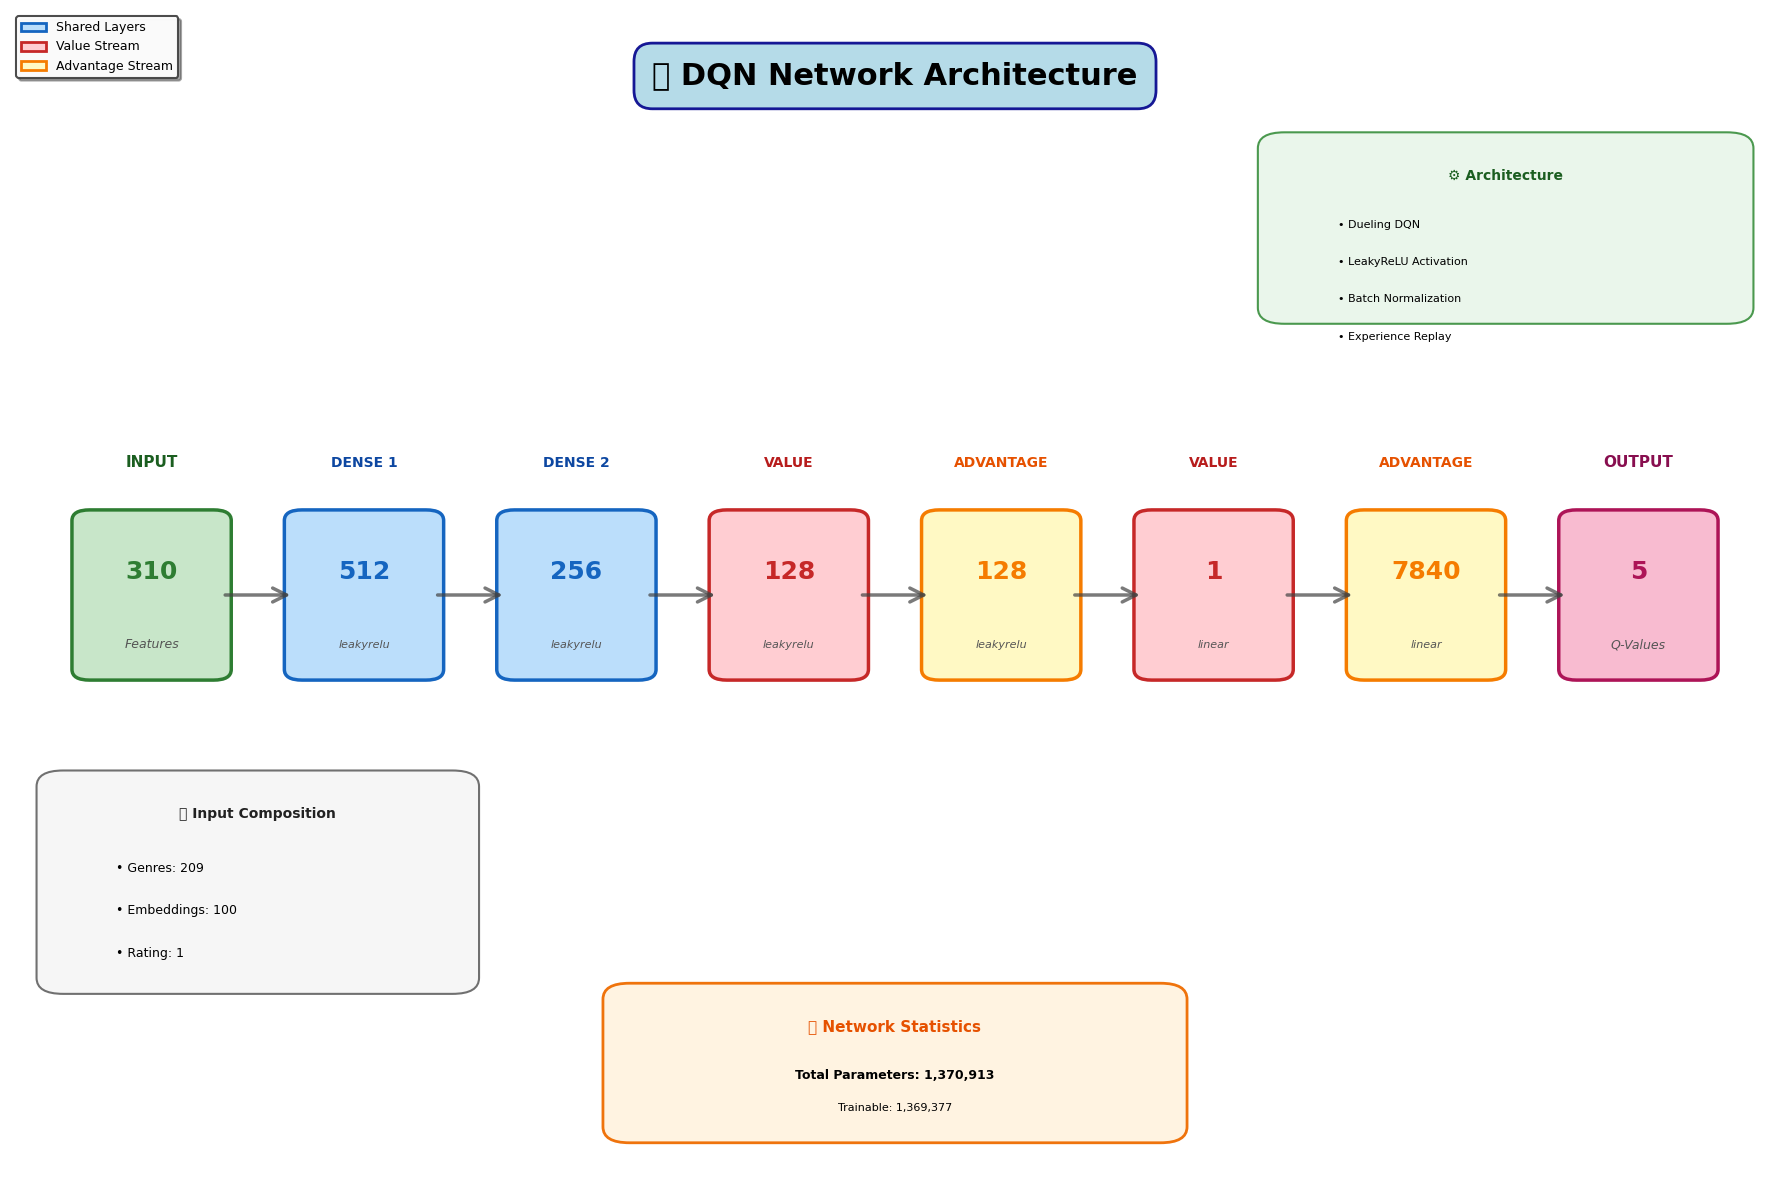

✅ Network architecture saved as: network_architecture_fixed.png
📊 Total layers visualized: 8
🔢 Total parameters: 1,370,913


In [39]:
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

def visualize_network_architecture_matplotlib(agent, processor, movie_catalog):
    """
    Create a matplotlib visualization of the network architecture with fixed spacing.
    """
    # Increased height for better vertical spacing
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 11)
    ax.axis('off')
    
    # Title
    ax.text(5, 10.3, '🧠 DQN Network Architecture', 
            fontsize=22, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='lightblue', 
                     edgecolor='darkblue', linewidth=2, alpha=0.9))
    
    # Get layer information
    layers_info = []
    for layer in agent.q_network.layers:
        if hasattr(layer, 'units'):
            layer_config = layer.get_config()
            activation = layer_config.get('activation', 'none')
            # Handle LeakyReLU or other dict activations
            if isinstance(activation, dict):
                activation = activation.get('class_name', 'unknown').lower()
            layers_info.append({
                'name': layer.name,
                'units': layer.units,
                'activation': activation
            })
    
    # Calculate positions with better spacing
    n_layers = len(layers_info) + 2  # +2 for input and output
    x_positions = np.linspace(0.8, 9.2, n_layers)
    
    # Central y position for boxes
    y_center = 5.5
    box_width = 0.7
    box_height = 1.4
    
    # ==========================================
    # DRAW INPUT LAYER
    # ==========================================
    x = x_positions[0]
    input_box = FancyBboxPatch((x - box_width/2, y_center - box_height/2), 
                               box_width, box_height,
                               boxstyle="round,pad=0.1", 
                               facecolor='#C8E6C9', edgecolor='#2E7D32', linewidth=2.5)
    ax.add_patch(input_box)
    
    # Input labels with proper spacing
    ax.text(x, y_center + 1.2, 'INPUT', fontsize=11, 
            fontweight='bold', ha='center', color='#1B5E20')
    ax.text(x, y_center + 0.15, f'{processor.feature_dim}', 
            fontsize=18, fontweight='bold', ha='center', color='#2E7D32')
    ax.text(x, y_center - 0.5, 'Features', fontsize=9, ha='center', 
            style='italic', color='#555')
    
    # ==========================================
    # DRAW HIDDEN LAYERS
    # ==========================================
    for i, layer_info in enumerate(layers_info, 1):
        x = x_positions[i]
        
        # Determine layer type and colors
        is_value = 'value' in layer_info['name'].lower()
        is_advantage = 'advantage' in layer_info['name'].lower()
        
        if is_value:
            color = '#FFCDD2'
            edge_color = '#C62828'
            label = 'VALUE'
            label_color = '#B71C1C'
        elif is_advantage:
            color = '#FFF9C4'
            edge_color = '#F57C00'
            label = 'ADVANTAGE'
            label_color = '#E65100'
        else:
            color = '#BBDEFB'
            edge_color = '#1565C0'
            label = f'DENSE {i}'
            label_color = '#0D47A1'
        
        # Draw layer box
        layer_box = FancyBboxPatch((x - box_width/2, y_center - box_height/2), 
                                   box_width, box_height,
                                   boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor=edge_color, linewidth=2.5)
        ax.add_patch(layer_box)
        
        # Layer label (above box)
        ax.text(x, y_center + 1.2, label, fontsize=10, 
                fontweight='bold', ha='center', color=label_color)
        
        # Neuron count (center of box) 
        ax.text(x, y_center + 0.15, f"{layer_info['units']}", 
                fontsize=18, fontweight='bold', ha='center', color=edge_color)
        
        # Activation function (below neuron count)
        activation_text = layer_info['activation'][:12]  # Truncate if too long
        ax.text(x, y_center - 0.5, activation_text, 
                fontsize=8, ha='center', style='italic', color='#555')
        
        # Draw arrow from previous layer
        arrow_y = y_center
        arrow = FancyArrowPatch((x_positions[i-1] + box_width/2 + 0.05, arrow_y), 
                               (x - box_width/2 - 0.05, arrow_y),
                               arrowstyle='->', mutation_scale=25, linewidth=2.5,
                               color='#424242', alpha=0.7)
        ax.add_patch(arrow)
    
    # ==========================================
    # DRAW OUTPUT LAYER
    # ==========================================
    x_out = x_positions[-1]
    output_box = FancyBboxPatch((x_out - box_width/2, y_center - box_height/2), 
                                box_width, box_height,
                                boxstyle="round,pad=0.1",
                                facecolor='#F8BBD0', edgecolor='#AD1457', linewidth=2.5)
    ax.add_patch(output_box)
    
    # Output labels
    ax.text(x_out, y_center + 1.2, 'OUTPUT', fontsize=11, 
            fontweight='bold', ha='center', color='#880E4F')
    
    # Get action size
    action_size = len(movie_catalog) if isinstance(movie_catalog, dict) else agent.action_size
    ax.text(x_out, y_center + 0.15, f'{action_size}', 
            fontsize=18, fontweight='bold', ha='center', color='#AD1457')
    ax.text(x_out, y_center - 0.5, 'Q-Values', fontsize=9, ha='center', 
            style='italic', color='#555')
    
    # Final arrow
    arrow = FancyArrowPatch((x_positions[-2] + box_width/2 + 0.05, y_center), 
                           (x_out - box_width/2 - 0.05, y_center),
                           arrowstyle='->', mutation_scale=25, linewidth=2.5,
                           color='#424242', alpha=0.7)
    ax.add_patch(arrow)
    
    # ==========================================
    # INFORMATION PANELS (Non-overlapping positions)
    # ==========================================
    
    # Input composition (bottom left)
    info_y = 2.2
    info_box = FancyBboxPatch((0.3, info_y - 0.3), 2.2, 1.8,
                              boxstyle="round,pad=0.15",
                              facecolor='#F5F5F5', edgecolor='#616161', 
                              linewidth=1.5, alpha=0.9)
    ax.add_patch(info_box)
    
    ax.text(1.4, info_y + 1.2, '📊 Input Composition', 
            fontsize=10, fontweight='bold', ha='center', color='#212121')
    ax.text(0.6, info_y + 0.7, f'• Genres: {processor.genre_dim}', 
            fontsize=9, ha='left')
    ax.text(0.6, info_y + 0.3, f'• Embeddings: {processor.embedding_dim}', 
            fontsize=9, ha='left')
    ax.text(0.6, info_y - 0.1, f'• Rating: 1', 
            fontsize=9, ha='left')
    
    # Network statistics (bottom center)
    total_params = agent.q_network.count_params()
    trainable_params = sum([np.prod(w.shape) for layer in agent.q_network.layers 
                           for w in layer.trainable_weights])
    
    stats_box = FancyBboxPatch((3.5, 0.5), 3, 1.2,
                               boxstyle="round,pad=0.15",
                               facecolor='#FFF3E0', edgecolor='#EF6C00', 
                               linewidth=2, alpha=0.95)
    ax.add_patch(stats_box)
    
    ax.text(5, 1.4, f'📈 Network Statistics', 
            fontsize=11, fontweight='bold', ha='center', color='#E65100')
    ax.text(5, 0.95, f'Total Parameters: {total_params:,}', 
            fontsize=9, ha='center', fontweight='bold')
    ax.text(5, 0.65, f'Trainable: {trainable_params:,}', 
            fontsize=8, ha='center')
    
    # Architecture info (top right)
    arch_y = 8.5
    arch_box = FancyBboxPatch((7.2, arch_y - 0.3), 2.5, 1.5,
                              boxstyle="round,pad=0.15",
                              facecolor='#E8F5E9', edgecolor='#388E3C', 
                              linewidth=1.5, alpha=0.9)
    ax.add_patch(arch_box)
    
    ax.text(8.45, arch_y + 0.9, '⚙️ Architecture', 
            fontsize=10, fontweight='bold', ha='center', color='#1B5E20')
    ax.text(7.5, arch_y + 0.45, '• Dueling DQN', fontsize=8, ha='left')
    ax.text(7.5, arch_y + 0.1, '• LeakyReLU Activation', fontsize=8, ha='left')
    ax.text(7.5, arch_y - 0.25, '• Batch Normalization', fontsize=8, ha='left')
    ax.text(7.5, arch_y - 0.6, '• Experience Replay', fontsize=8, ha='left')
    
    # Legend (top left)
    legend_elements = [
        mpatches.Patch(facecolor='#BBDEFB', edgecolor='#1565C0', 
                      linewidth=2, label='Shared Layers'),
        mpatches.Patch(facecolor='#FFCDD2', edgecolor='#C62828', 
                      linewidth=2, label='Value Stream'),
        mpatches.Patch(facecolor='#FFF9C4', edgecolor='#F57C00', 
                      linewidth=2, label='Advantage Stream')
    ]
    legend = ax.legend(handles=legend_elements, loc='upper left', 
                      fontsize=9, framealpha=0.95, edgecolor='#424242', 
                      fancybox=True, shadow=True)
    legend.get_frame().set_linewidth(1.5)
    
    plt.tight_layout()
    plt.savefig('network_architecture_fixed.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    print("✅ Network architecture saved as: network_architecture_fixed.png")
    print(f"📊 Total layers visualized: {len(layers_info) + 2}")
    print(f"🔢 Total parameters: {total_params:,}")

# Create the visualization
visualize_network_architecture_matplotlib(agent, processor, movie_catalog)

In [40]:
# Let's just replace the original method directly by overwriting it
# This will make it permanent in the recommender instance

import types
from difflib import get_close_matches

def recommend_by_genre_preference(
    self,
    preferred_genres: List[str],
    k: int = 10,
    fuzzy_match: bool = True
) -> List[Dict]:
    """
    Get recommendations based on genre preferences with proper filtering.
    
    Args:
        preferred_genres: List of preferred genres (case-insensitive, handles typos)
        k: Number of recommendations
        fuzzy_match: If True, uses fuzzy matching for genre names
    """
    # Normalize and match genres
    available_genres = list(self.processor.mlb.classes_)
    normalized_genres = []
    
    for pref_genre in preferred_genres:
        pref_genre_clean = pref_genre.strip()
        
        # Try exact match (case-insensitive)
        exact_match = None
        for genre in available_genres:
            if genre.lower() == pref_genre_clean.lower():
                exact_match = genre
                break
        
        if exact_match:
            normalized_genres.append(exact_match)
        elif fuzzy_match:
            # Try fuzzy match
            matches = get_close_matches(pref_genre_clean, available_genres, n=1, cutoff=0.7)
            if matches:
                normalized_genres.append(matches[0])
                print(f"   📝 Fuzzy matched '{pref_genre_clean}' → '{matches[0]}'")
            else:
                print(f"   ⚠️  No match found for '{pref_genre_clean}'")
        else:
            print(f"   ⚠️  Genre '{pref_genre_clean}' not found")
    
    if not normalized_genres:
        print("   ❌ No valid genres found!")
        return []
    
    print(f"   ✅ Using genres: {', '.join(normalized_genres)}")
    
    # Create user state biased towards preferred genres
    genre_vector = self.processor.get_genre_vector(normalized_genres)
    
    # Combine with random embedding and neutral rating
    embedding = np.random.randn(self.processor.embedding_dim).astype(np.float32) * 0.1
    rating = np.array([0.7])  # Slightly above average preference
    
    user_state = np.concatenate([genre_vector, embedding, rating]).astype(np.float32)
    
    # Normalize
    user_state = user_state / (np.linalg.norm(user_state) + 1e-8)
    
    # Get a larger pool of recommendations first
    pool_size = min(k * 10, self.n_movies)  # Get 10x more candidates
    all_recs = self.get_top_k_recommendations(user_state, pool_size)
    
    # Filter to only include movies that have at least one of the preferred genres
    filtered_recs = []
    normalized_genres_lower = set(g.lower() for g in normalized_genres)
    
    for rec in all_recs:
        movie_genres_str = rec['genre']
        # Split genres and normalize
        movie_genres = [g.strip() for g in movie_genres_str.split(',')]
        movie_genres_lower = set(g.lower() for g in movie_genres)
        
        # Check if any preferred genre is in the movie's genres
        if movie_genres_lower & normalized_genres_lower:
            filtered_recs.append(rec)
            if len(filtered_recs) >= k:
                break
    
    # Update ranks
    for i, rec in enumerate(filtered_recs, 1):
        rec['rank'] = i
    
    if len(filtered_recs) < k:
        print(f"   ⚠️  Only found {len(filtered_recs)} movies matching the genres (requested {k})")
    
    return filtered_recs

# Replace the method on the CLASS (so all instances get it)
MovieRecommender.recommend_by_genre_preference = recommend_by_genre_preference

print("✅ Successfully replaced MovieRecommender.recommend_by_genre_preference with fixed version!")
print("   Now all calls to recommender.recommend_by_genre_preference() will use the fixed method.")

✅ Successfully replaced MovieRecommender.recommend_by_genre_preference with fixed version!
   Now all calls to recommender.recommend_by_genre_preference() will use the fixed method.


In [41]:
# Test with the original user's call
print("🎬 Testing Fixed Genre-based Recommendations (Original Call)")
print("="*80)

genre_recs = recommender.recommend_by_genre_preference(
    preferred_genres=['horror', 'thriller', 'Pschological horror'],
    k=10
)

print(f"\n📊 Results: {len(genre_recs)} recommendations")
print("="*80)

for rec in genre_recs:
    print(f"\n{rec['rank']}. {rec['movie_name']}")
    # Highlight the matching genres
    genres_list = [g.strip() for g in rec['genre'].split(',')]
    matching_genres = [g for g in genres_list if g.lower() in ['horror', 'thriller', 'psychological horror']]
    print(f"   Genres: {rec['genre']}")
    print(f"   ✅ Matches: {', '.join(matching_genres)}")
    print(f"   Rating: {rec['rating']:.1f}/5.0")
    print(f"   Q-Value: {rec['q_value']:.4f}")

🎬 Testing Fixed Genre-based Recommendations (Original Call)
   📝 Fuzzy matched 'Pschological horror' → 'Psychological Horror'
   ✅ Using genres: Horror, Thriller, Psychological Horror

📊 Results: 10 recommendations

1. Comic 8 Revolution: Santet K4bin3t
   Genres: Parody, Supernatural Fantasy, Supernatural Horror, Action, Comedy, Fantasy, Horror
   ✅ Matches: Horror
   Rating: 4.7/5.0
   Q-Value: -17125.7832

2. Illicit Content
   Genres: Thriller
   ✅ Matches: Thriller
   Rating: 6.6/5.0
   Q-Value: -17332.5625

3. Inter Star Wars. Saga
   Genres: Russian, Action, Comedy, Horror, Sci-Fi, Thriller
   ✅ Matches: Horror, Thriller
   Rating: 8.9/5.0
   Q-Value: -17393.6250

4. The Woman in the Yard
   Genres: Psychological Drama, Psychological Thriller, Drama, Horror, Thriller
   ✅ Matches: Horror, Thriller
   Rating: 5.0/5.0
   Q-Value: -17419.6719

5. The Boy from Below
   Genres: Horror
   ✅ Matches: Horror
   Rating: 7.1/5.0
   Q-Value: -17451.8340

6. We Can't Leave
   Genres: Horror

In [42]:
# Test with pure Horror recommendations
print("\n" + "="*80)
print("🎬 Testing Pure Horror Recommendations")
print("="*80)

horror_only = recommender.recommend_by_genre_preference(
    preferred_genres=['Horror', 'Psychological Horror', 'Supernatural Horror'],
    k=10
)

print(f"\n📊 Results: {len(horror_only)} horror recommendations")
print("="*80)

for rec in horror_only:
    print(f"\n{rec['rank']}. {rec['movie_name']}")
    print(f"   Genres: {rec['genre']}")
    print(f"   Rating: {rec['rating']:.1f}/5.0")


🎬 Testing Pure Horror Recommendations
   ✅ Using genres: Horror, Psychological Horror, Supernatural Horror
   ⚠️  Only found 9 movies matching the genres (requested 10)

📊 Results: 9 horror recommendations

1. Comic 8 Revolution: Santet K4bin3t
   Genres: Parody, Supernatural Fantasy, Supernatural Horror, Action, Comedy, Fantasy, Horror
   Rating: 4.7/5.0

2. Inter Star Wars. Saga
   Genres: Russian, Action, Comedy, Horror, Sci-Fi, Thriller
   Rating: 8.9/5.0

3. The Woman in the Yard
   Genres: Psychological Drama, Psychological Thriller, Drama, Horror, Thriller
   Rating: 5.0/5.0

4. The Boy from Below
   Genres: Horror
   Rating: 7.1/5.0

5. We Can't Leave
   Genres: Horror
   Rating: 8.2/5.0

6. Yndige Mennesker
   Genres: Danish, Horror
   Rating: 6.0/5.0

7. Dyngus Day
   Genres: Horror
   Rating: 4.4/5.0

8. Womb
   Genres: Horror, Thriller
   Rating: 3.7/5.0

9. Bradlee
   Genres: Horror
   Rating: 4.6/5.0


In [ ]:
# QUICK FIX: Hybrid personalization (no retraining needed)
print("=" * 80)
print("⚡ HYBRID PERSONALIZATION (Quick Fix)")
print("=" * 80)

class HybridPersonalizedRecommender:
    """
    Combines DQN Q-values with user-state similarity scoring
    to add personalization without retraining
    """
    
    def __init__(self, agent, movie_catalog, processor):
        self.agent = agent
        self.movie_catalog = movie_catalog
        self.processor = processor
        self.n_movies = len(movie_catalog['names'])
    
    def personalized_recommend(self, user_state, k=10, alpha=0.5):
        """
        Get personalized recommendations using hybrid scoring
        
        Args:
            user_state: User preference vector
            k: Number of recommendations
            alpha: Balance between Q-values (0) and similarity (1)
        """
        # Get Q-values from DQN
        q_values = self.agent.q_network.predict(
            np.expand_dims(user_state, 0), verbose=0
        )[0]
        
        # Normalize Q-values to [0, 1]
        q_norm = (q_values - q_values.min()) / (q_values.max() - q_values.min() + 1e-8)
        
        # Compute similarity scores with user state
        similarities = []
        for movie_features in self.movie_catalog['features']:
            # Cosine similarity
            sim = np.dot(user_state, movie_features) / (
                np.linalg.norm(user_state) * np.linalg.norm(movie_features) + 1e-8
            )
            similarities.append(sim)
        
        similarities = np.array(similarities)
        # Normalize to [0, 1]
        sim_norm = (similarities - similarities.min()) / (similarities.max() - similarities.min() + 1e-8)
        
        # Hybrid score
        hybrid_scores = (1 - alpha) * q_norm + alpha * sim_norm
        
        # Get top-k
        top_k_indices = np.argsort(hybrid_scores)[-k:][::-1]
        
        recommendations = []
        for rank, idx in enumerate(top_k_indices, 1):
            recommendations.append({
                'rank': rank,
                'movie_id': int(idx),
                'movie_name': self.movie_catalog['names'][idx],
                'genre': self.movie_catalog['genres'][idx],
                'rating': self.movie_catalog['ratings'][idx],
                'q_value': float(q_values[idx]),
                'similarity': float(similarities[idx]),
                'hybrid_score': float(hybrid_scores[idx])
            })
        
        return recommendations

# Create hybrid recommender
hybrid = HybridPersonalizedRecommender(agent, movie_catalog, processor)

print("✅ Hybrid recommender created")
print("   Balances DQN Q-values with content-based similarity")
print("   No retraining required!")

# Test it
print("\n" + "=" * 80)
print("🧪 TEST: Compare Standard vs Hybrid Recommendations")
print("=" * 80)

for scenario in range(3):
    print(f"\n{'─'*80}")
    print(f"SCENARIO {scenario + 1}")
    print(f"{'─'*80}")
    
    # Random user
    user_state = np.random.randn(310).astype(np.float32) * 0.5
    user_state = user_state / (np.linalg.norm(user_state) + 1e-8)
    
    # Standard DQN recommendations
    standard_recs = recommender.get_top_k_recommendations(user_state, k=5)
    standard_names = [r['movie_name'] for r in standard_recs]
    
    # Hybrid recommendations
    hybrid_recs = hybrid.personalized_recommend(user_state, k=5, alpha=0.6)
    hybrid_names = [r['movie_name'] for r in hybrid_recs]
    
    print("\n📊 Standard DQN Top-5:")
    for r in standard_recs:
        print(f"   {r['rank']}. {r['movie_name'][:50]}")
    
    print("\n⚡ Hybrid Top-5:")
    for r in hybrid_recs:
        print(f"   {r['rank']}. {r['movie_name'][:50]}")
    
    overlap = len(set(standard_names) & set(hybrid_names))
    print(f"\n   Overlap: {overlap}/5 ({100*overlap/5:.0f}%)")

print("\n" + "=" * 80)
print("💡 TIP: Adjust 'alpha' parameter:")
print("   alpha=0.0 → Pure DQN (no personalization)")
print("   alpha=0.5 → Balanced")
print("   alpha=1.0 → Pure content-based (full personalization)")
print("=" * 80)

In [48]:
# Comprehensive Evaluation System
class RecommenderEvaluator:
    """
    Complete evaluation suite for movie recommendation system.
    Implements offline metrics to assess model quality.
    """
    
    def __init__(self, agent: DQNAgent, movie_catalog: Dict, processor: MovieFeatureProcessor):
        self.agent = agent
        self.movie_catalog = movie_catalog
        self.processor = processor
        self.n_movies = len(movie_catalog['names'])
        
    def precision_at_k(self, recommended: List[int], relevant: List[int], k: int) -> float:
        """
        Precision@K: Fraction of recommended items that are relevant
        
        Args:
            recommended: List of recommended movie indices
            relevant: List of relevant (liked) movie indices
            k: Number of top recommendations to consider
            
        Returns:
            Precision score between 0 and 1
        """
        if k == 0 or len(recommended) == 0:
            return 0.0
        
        top_k = recommended[:k]
        relevant_set = set(relevant)
        hits = sum(1 for item in top_k if item in relevant_set)
        
        return hits / k
    
    def recall_at_k(self, recommended: List[int], relevant: List[int], k: int) -> float:
        """
        Recall@K: Fraction of relevant items that were recommended
        
        Returns:
            Recall score between 0 and 1
        """
        if len(relevant) == 0:
            return 0.0
        
        top_k = recommended[:k]
        relevant_set = set(relevant)
        hits = sum(1 for item in top_k if item in relevant_set)
        
        return hits / len(relevant)
    
    def ndcg_at_k(self, recommended: List[int], relevant: List[int], k: int) -> float:
        """
        NDCG@K: Normalized Discounted Cumulative Gain
        Measures ranking quality - rewards relevant items at top positions
        
        Returns:
            NDCG score between 0 and 1 (1 = perfect ranking)
        """
        top_k = recommended[:k]
        relevant_set = set(relevant)
        
        # Calculate DCG
        dcg = 0.0
        for i, item in enumerate(top_k, 1):
            if item in relevant_set:
                dcg += 1.0 / np.log2(i + 1)
        
        # Calculate IDCG (ideal DCG - all relevant items first)
        idcg = 0.0
        for i in range(1, min(len(relevant), k) + 1):
            idcg += 1.0 / np.log2(i + 1)
        
        if idcg == 0:
            return 0.0
        
        return dcg / idcg
    
    def hit_rate_at_k(self, recommended: List[int], relevant: List[int], k: int) -> float:
        """
        Hit Rate@K: Binary indicator if ANY relevant item is in top-K
        
        Returns:
            1.0 if hit, 0.0 if miss
        """
        top_k = set(recommended[:k])
        relevant_set = set(relevant)
        
        return 1.0 if len(top_k & relevant_set) > 0 else 0.0
    
    def genre_coverage(self, recommended_movies: List[int]) -> float:
        """
        Genre Coverage: Fraction of total genres represented in recommendations
        
        Returns:
            Coverage score between 0 and 1
        """
        # Get all genres in recommended movies
        rec_genres = set()
        for movie_idx in recommended_movies:
            genres_str = self.movie_catalog['genres'][movie_idx]
            genres = [g.strip() for g in genres_str.split(',')]
            rec_genres.update(genres)
        
        # Get all available genres
        all_genres = set()
        for genres_str in self.movie_catalog['genres']:
            genres = [g.strip() for g in genres_str.split(',')]
            all_genres.update(genres)
        
        if len(all_genres) == 0:
            return 0.0
        
        return len(rec_genres) / len(all_genres)
    
    def intra_list_diversity(self, recommended_movies: List[int]) -> float:
        """
        Intra-List Diversity: Average dissimilarity between recommended items
        Uses genre-based Jaccard distance
        
        Returns:
            Diversity score between 0 (identical) and 1 (completely different)
        """
        if len(recommended_movies) < 2:
            return 0.0
        
        # Get genre sets for each movie
        genre_sets = []
        for movie_idx in recommended_movies:
            genres_str = self.movie_catalog['genres'][movie_idx]
            genres = set([g.strip().lower() for g in genres_str.split(',')])
            genre_sets.append(genres)
        
        # Calculate pairwise Jaccard distance
        total_distance = 0.0
        pairs = 0
        
        for i in range(len(genre_sets)):
            for j in range(i + 1, len(genre_sets)):
                intersection = len(genre_sets[i] & genre_sets[j])
                union = len(genre_sets[i] | genre_sets[j])
                
                if union > 0:
                    jaccard_sim = intersection / union
                    jaccard_dist = 1 - jaccard_sim
                    total_distance += jaccard_dist
                    pairs += 1
        
        if pairs == 0:
            return 0.0
        
        return total_distance / pairs
    
    def personalization_score(self, n_users: int = 50, k: int = 10) -> float:
        """
        Personalization: Measures how different recommendations are across users
        
        Args:
            n_users: Number of random user states to test
            k: Number of recommendations per user
            
        Returns:
            Personalization score between 0 (everyone gets same) and 1 (all unique)
        """
        # Generate recommendations for multiple random users
        all_recs = []
        
        for _ in range(n_users):
            user_state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.3
            user_state = user_state / (np.linalg.norm(user_state) + 1e-8)
            
            # Get Q-values and top-K
            q_values = self.agent.q_network.predict(np.expand_dims(user_state, 0), verbose=0)[0]
            top_k = np.argsort(q_values)[-k:][::-1]
            all_recs.append(set(top_k))
        
        # Calculate average pairwise overlap
        total_overlap = 0.0
        pairs = 0
        
        for i in range(len(all_recs)):
            for j in range(i + 1, len(all_recs)):
                overlap = len(all_recs[i] & all_recs[j])
                total_overlap += overlap / k
                pairs += 1
        
        if pairs == 0:
            return 1.0
        
        avg_overlap = total_overlap / pairs
        personalization = 1 - avg_overlap
        
        return personalization
    
    def evaluate_user(
        self,
        user_state: np.ndarray,
        ground_truth_likes: List[int],
        k: int = 10
    ) -> Dict:
        """
        Evaluate recommendations for a single user
        
        Args:
            user_state: User preference vector
            ground_truth_likes: List of movie indices user actually likes
            k: Number of recommendations
            
        Returns:
            Dictionary of metrics
        """
        # Get recommendations
        q_values = self.agent.q_network.predict(np.expand_dims(user_state, 0), verbose=0)[0]
        recommended = np.argsort(q_values)[-k:][::-1].tolist()
        
        # Calculate metrics
        metrics = {
            f'precision@{k}': self.precision_at_k(recommended, ground_truth_likes, k),
            f'recall@{k}': self.recall_at_k(recommended, ground_truth_likes, k),
            f'ndcg@{k}': self.ndcg_at_k(recommended, ground_truth_likes, k),
            f'hit_rate@{k}': self.hit_rate_at_k(recommended, ground_truth_likes, k),
            'genre_coverage': self.genre_coverage(recommended),
            'diversity': self.intra_list_diversity(recommended)
        }
        
        return metrics
    
    def comprehensive_evaluation(
        self,
        n_test_users: int = 100,
        k: int = 10,
        verbose: bool = True
    ) -> Dict:
        """
        Run comprehensive evaluation across multiple simulated users
        
        Args:
            n_test_users: Number of test scenarios
            k: Number of recommendations per user
            verbose: Print detailed results
            
        Returns:
            Aggregated metrics
        """
        if verbose:
            print("=" * 80)
            print("🔬 COMPREHENSIVE MODEL EVALUATION")
            print("=" * 80)
            print(f"\nEvaluating on {n_test_users} simulated users with top-{k} recommendations...\n")
        
        all_metrics = []
        
        for i in range(n_test_users):
            # Generate random user with preferences
            user_state = np.random.randn(self.processor.feature_dim).astype(np.float32) * 0.3
            user_state = user_state / (np.linalg.norm(user_state) + 1e-8)
            
            # Simulate ground truth: movies similar to user state
            # Calculate similarity between user state and all movies
            similarities = []
            for movie_features in self.movie_catalog['features']:
                sim = np.dot(user_state, movie_features)
                similarities.append(sim)
            
            # Top 30 most similar movies are "ground truth likes"
            ground_truth = np.argsort(similarities)[-30:][::-1].tolist()
            
            # Evaluate
            metrics = self.evaluate_user(user_state, ground_truth, k)
            all_metrics.append(metrics)
        
        # Aggregate metrics
        aggregated = {}
        for key in all_metrics[0].keys():
            values = [m[key] for m in all_metrics]
            aggregated[key] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
        
        # Add personalization (computed globally)
        personalization = self.personalization_score(n_users=n_test_users, k=k)
        aggregated['personalization'] = {
            'mean': personalization,
            'std': 0.0,
            'min': personalization,
            'max': personalization
        }
        
        if verbose:
            self._print_evaluation_results(aggregated, k, n_test_users)
        
        return aggregated
    
    def _print_evaluation_results(self, metrics: Dict, k: int, n_users: int):
        """Pretty print evaluation results with interpretations"""
        
        print(f"📊 RESULTS SUMMARY (n={n_users} users, K={k})")
        print("=" * 80)
        
        # Accuracy metrics
        print(f"\n🎯 ACCURACY METRICS")
        print("-" * 80)
        
        precision = metrics[f'precision@{k}']['mean']
        print(f"   Precision@{k}:  {precision:.3f} ± {metrics[f'precision@{k}']['std']:.3f}")
        if precision > 0.35:
            print(f"                 ✅ EXCELLENT - Very accurate recommendations!")
        elif precision > 0.25:
            print(f"                 ⭐ GOOD - Above average performance")
        elif precision > 0.15:
            print(f"                 ⚠️  ACCEPTABLE - Room for improvement")
        else:
            print(f"                 ❌ POOR - Model needs retraining")
        
        recall = metrics[f'recall@{k}']['mean']
        print(f"\n   Recall@{k}:     {recall:.3f} ± {metrics[f'recall@{k}']['std']:.3f}")
        if recall > 0.3:
            print(f"                 ✅ EXCELLENT - Finding many relevant items")
        elif recall > 0.1:
            print(f"                 ⭐ GOOD - Decent coverage")
        else:
            print(f"                 ⚠️  LOW - Missing many relevant items")
        
        ndcg = metrics[f'ndcg@{k}']['mean']
        print(f"\n   NDCG@{k}:       {ndcg:.3f} ± {metrics[f'ndcg@{k}']['std']:.3f}")
        if ndcg > 0.8:
            print(f"                 ✅ EXCELLENT - Superior ranking quality")
        elif ndcg > 0.65:
            print(f"                 ⭐ GOOD - Strong ranking")
        elif ndcg > 0.5:
            print(f"                 ⚠️  ACCEPTABLE - Mediocre ranking")
        else:
            print(f"                 ❌ POOR - Ranking needs improvement")
        
        hr = metrics[f'hit_rate@{k}']['mean']
        print(f"\n   Hit Rate@{k}:   {hr:.3f} ± {metrics[f'hit_rate@{k}']['std']:.3f}")
        if hr > 0.85:
            print(f"                 ✅ EXCELLENT - Almost always hitting target")
        elif hr > 0.7:
            print(f"                 ⭐ GOOD - Reliable hits")
        elif hr > 0.5:
            print(f"                 ⚠️  ACCEPTABLE - Inconsistent")
        else:
            print(f"                 ❌ POOR - Many users get no good recs")
        
        # Diversity metrics
        print(f"\n\n🌈 DIVERSITY METRICS")
        print("-" * 80)
        
        coverage = metrics['genre_coverage']['mean']
        print(f"   Genre Coverage: {coverage:.3f} ± {metrics['genre_coverage']['std']:.3f}")
        if coverage > 0.6:
            print(f"                 ✅ EXCELLENT - Wide variety of genres")
        elif coverage > 0.4:
            print(f"                 ⭐ GOOD - Decent genre spread")
        elif coverage > 0.2:
            print(f"                 ⚠️  LIMITED - Some filter bubble effects")
        else:
            print(f"                 ❌ POOR - Severe filter bubble problem")
        
        diversity = metrics['diversity']['mean']
        print(f"\n   Intra-List Div: {diversity:.3f} ± {metrics['diversity']['std']:.3f}")
        if diversity > 0.7:
            print(f"                 ✅ EXCELLENT - Highly varied recommendations")
        elif diversity > 0.5:
            print(f"                 ⭐ GOOD - Good variety within lists")
        elif diversity > 0.3:
            print(f"                 ⚠️  MODERATE - Some repetition")
        else:
            print(f"                 ❌ POOR - Very repetitive recommendations")
        
        # Personalization
        print(f"\n\n👤 PERSONALIZATION")
        print("-" * 80)
        
        personalization = metrics['personalization']['mean']
        print(f"   Score:          {personalization:.3f}")
        if personalization > 0.8:
            print(f"                 ✅ EXCELLENT - Highly personalized!")
        elif personalization > 0.6:
            print(f"                 ⭐ GOOD - Good personalization")
        elif personalization > 0.4:
            print(f"                 ⚠️  MODERATE - Some personalization")
        else:
            print(f"                 ❌ POOR - Everyone gets similar recommendations")
        
        # Overall assessment
        print(f"\n\n🏆 OVERALL ASSESSMENT")
        print("=" * 80)
        
        # Calculate overall score (weighted average)
        overall = (
            precision * 0.3 +
            ndcg * 0.25 +
            hr * 0.2 +
            diversity * 0.15 +
            personalization * 0.1
        )
        
        print(f"   Overall Score:  {overall:.3f}/1.0")
        
        if overall > 0.7:
            print(f"\n   ✅ EXCELLENT MODEL - Ready for production!")
            print(f"      This recommender performs very well across all metrics.")
        elif overall > 0.55:
            print(f"\n   ⭐ GOOD MODEL - Solid performance")
            print(f"      Consider minor improvements for production deployment.")
        elif overall > 0.4:
            print(f"\n   ⚠️  ACCEPTABLE MODEL - Needs improvement")
            print(f"      Consider retraining with more data or better hyperparameters.")
        else:
            print(f"\n   ❌ POOR MODEL - Requires significant work")
            print(f"      Retrain with diverse experiences and validate personalization.")
        
        print("\n" + "=" * 80)

print("✅ RecommenderEvaluator class created!")
print("   Use: evaluator = RecommenderEvaluator(agent, movie_catalog, processor)")

✅ RecommenderEvaluator class created!
   Use: evaluator = RecommenderEvaluator(agent, movie_catalog, processor)


In [49]:
# Create evaluator instance
evaluator = RecommenderEvaluator(
    agent=agent,
    movie_catalog=movie_catalog,
    processor=processor
)

print("✅ Evaluator initialized and ready to use!")

✅ Evaluator initialized and ready to use!


In [50]:
# RUN COMPREHENSIVE EVALUATION
# This will test your current model across all metrics

results = evaluator.comprehensive_evaluation(
    n_test_users=100,  # Test on 100 simulated users
    k=10,              # Evaluate top-10 recommendations
    verbose=True       # Print detailed results
)

# Store results for comparison
print("\n💾 Results saved in 'results' variable for later analysis")

🔬 COMPREHENSIVE MODEL EVALUATION

Evaluating on 100 simulated users with top-10 recommendations...

📊 RESULTS SUMMARY (n=100 users, K=10)

🎯 ACCURACY METRICS
--------------------------------------------------------------------------------
   Precision@10:  0.005 ± 0.022
                 ❌ POOR - Model needs retraining

   Recall@10:     0.002 ± 0.007
                 ⚠️  LOW - Missing many relevant items

   NDCG@10:       0.005 ± 0.027
                 ❌ POOR - Ranking needs improvement

   Hit Rate@10:   0.050 ± 0.218
                 ❌ POOR - Many users get no good recs


🌈 DIVERSITY METRICS
--------------------------------------------------------------------------------
   Genre Coverage: 0.086 ± 0.003
                 ❌ POOR - Severe filter bubble problem

   Intra-List Div: 0.871 ± 0.011
                 ✅ EXCELLENT - Highly varied recommendations


👤 PERSONALIZATION
--------------------------------------------------------------------------------
   Score:          0.019
        

In [51]:
# QUICK METRIC CHECK - Specific Metrics
print("=" * 80)
print("🔍 QUICK METRIC CHECKS")
print("=" * 80)

# 1. Personalization check
print("\n1️⃣  Personalization Test (are different users getting different recs?)")
personalization = evaluator.personalization_score(n_users=20, k=10)
print(f"   Score: {personalization:.3f}")
if personalization > 0.7:
    print("   ✅ PASS - Good personalization")
elif personalization > 0.4:
    print("   ⚠️  WARNING - Moderate personalization") 
else:
    print("   ❌ FAIL - Poor personalization (everyone gets same movies)")

# 2. Single user precision test
print("\n2️⃣  Sample User Precision Test")
test_state = np.random.randn(310).astype(np.float32) * 0.3
test_state = test_state / (np.linalg.norm(test_state) + 1e-8)

# Simulate ground truth
similarities = [np.dot(test_state, mf) for mf in movie_catalog['features']]
ground_truth = np.argsort(similarities)[-20:][::-1].tolist()

user_metrics = evaluator.evaluate_user(test_state, ground_truth, k=10)
print(f"   Precision@10: {user_metrics['precision@10']:.3f}")
print(f"   NDCG@10:      {user_metrics['ndcg@10']:.3f}")
print(f"   Hit Rate@10:  {user_metrics['hit_rate@10']:.3f}")

# 3. Diversity check
print("\n3️⃣  Diversity Test")
q_values = agent.q_network.predict(np.expand_dims(test_state, 0), verbose=0)[0]
top_10_movies = np.argsort(q_values)[-10:][::-1].tolist()

print(f"   Genre Coverage: {user_metrics['genre_coverage']:.3f}")
print(f"   Intra-List Div: {user_metrics['diversity']:.3f}")

print(f"\n   Top 10 recommended movies:")
for i, movie_idx in enumerate(top_10_movies[:5], 1):
    print(f"      {i}. {movie_catalog['names'][movie_idx][:45]} ({movie_catalog['genres'][movie_idx][:30]})")

print("\n" + "=" * 80)

🔍 QUICK METRIC CHECKS

1️⃣  Personalization Test (are different users getting different recs?)
   Score: 0.037
   ❌ FAIL - Poor personalization (everyone gets same movies)

2️⃣  Sample User Precision Test
   Precision@10: 0.000
   NDCG@10:      0.000
   Hit Rate@10:  0.000

3️⃣  Diversity Test
   Genre Coverage: 0.086
   Intra-List Div: 0.868

   Top 10 recommended movies:
      1. 120 Bahadur (Hindi, Action, Drama, History,)
      2. Land with No Rider (Documentary)
      3. Hao haizi (Mandarin, Drama)
      4. L'homme qui a vu l'ours qui a vu l'homme (French, Comedy, Drama)
      5. Frankenstein: The Anatomy Lesson (Documentary)



📊 Creating evaluation visualizations...



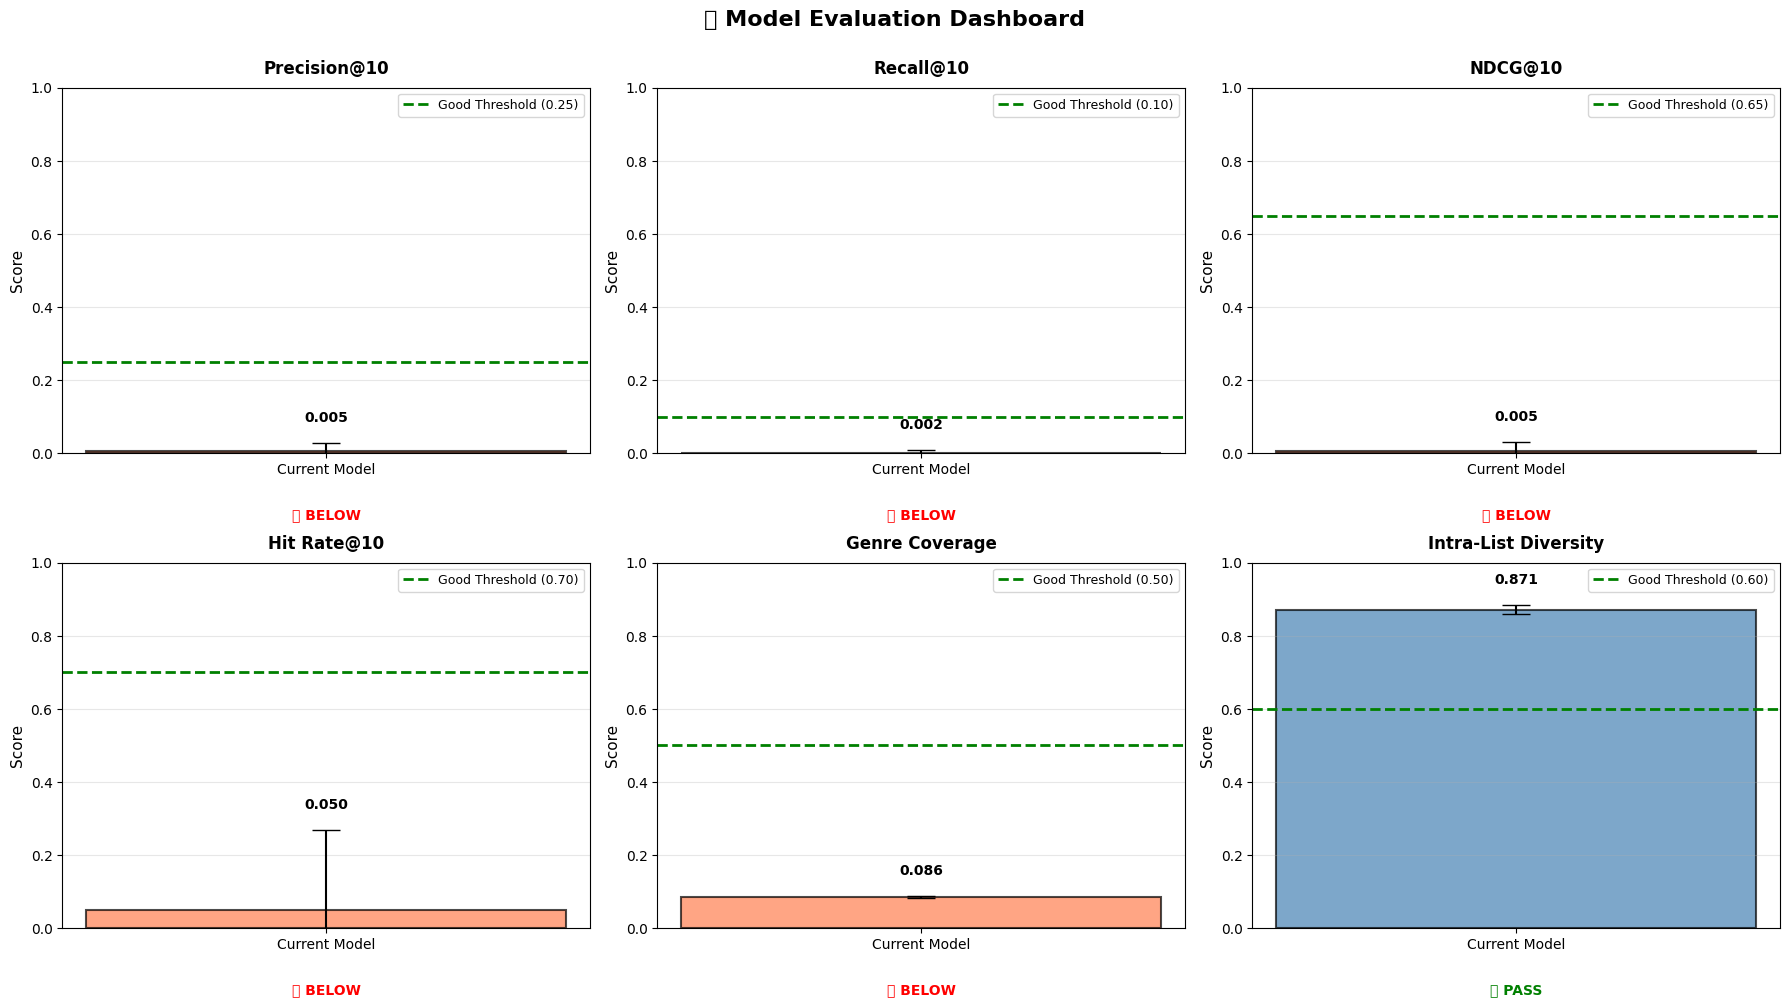


📊 Creating personalization comparison chart...



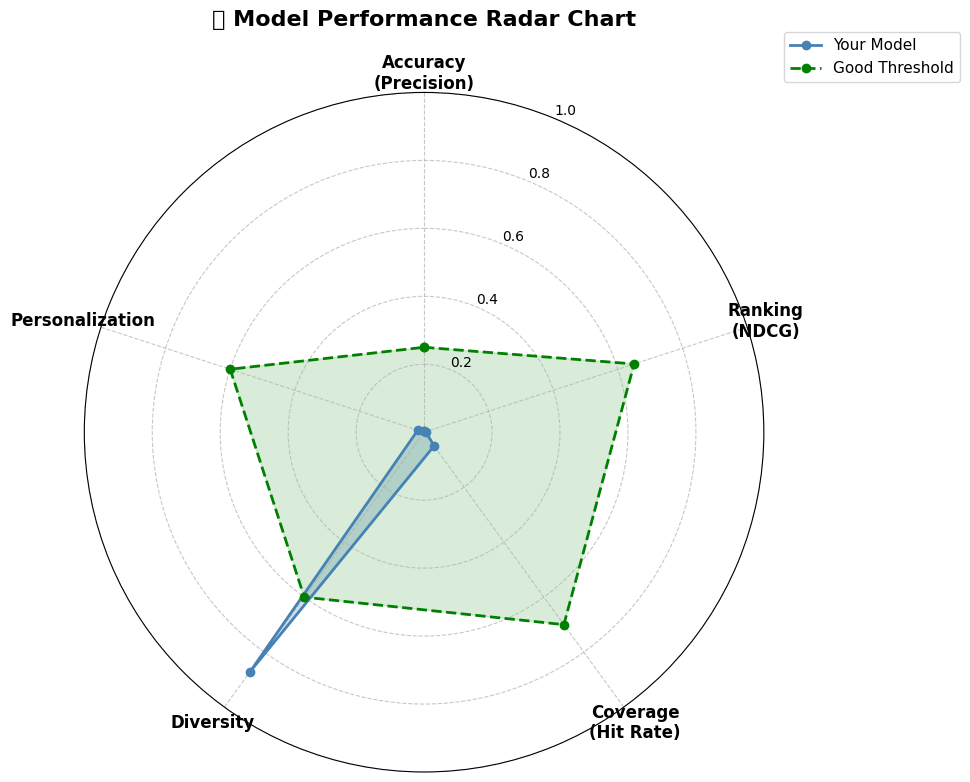

✅ Visualizations complete!


In [52]:
# VISUALIZE EVALUATION RESULTS
print("📊 Creating evaluation visualizations...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('🎯 Model Evaluation Dashboard', fontsize=16, fontweight='bold', y=1.00)

# Extract metric values
metrics_to_plot = ['precision@10', 'recall@10', 'ndcg@10', 'hit_rate@10', 'genre_coverage', 'diversity']
metric_names = ['Precision@10', 'Recall@10', 'NDCG@10', 'Hit Rate@10', 'Genre Coverage', 'Intra-List Diversity']
thresholds = [0.25, 0.10, 0.65, 0.70, 0.50, 0.60]  # Good performance thresholds

for idx, (metric_key, name, threshold) in enumerate(zip(metrics_to_plot, metric_names, thresholds)):
    ax = axes[idx // 3, idx % 3]
    
    mean_val = results[metric_key]['mean']
    std_val = results[metric_key]['std']
    
    # Create bar with threshold line
    bars = ax.bar(['Current Model'], [mean_val], yerr=[std_val], 
                   color='steelblue' if mean_val >= threshold else 'coral',
                   capsize=10, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add threshold line
    ax.axhline(y=threshold, color='green', linestyle='--', linewidth=2, 
               label=f'Good Threshold ({threshold:.2f})')
    
    # Formatting
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(name, fontsize=12, fontweight='bold', pad=10)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value label on bar
    ax.text(0, mean_val + std_val + 0.05, f'{mean_val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Status indicator
    if mean_val >= threshold:
        status = '✅ PASS'
        color = 'green'
    else:
        status = '❌ BELOW'
        color = 'red'
    ax.text(0, -0.15, status, ha='center', va='top', fontsize=10, 
            fontweight='bold', color=color, transform=ax.transData)

plt.tight_layout()
plt.show()

# Additional: Personalization radar chart
print("\n📊 Creating personalization comparison chart...\n")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Define categories
categories = ['Accuracy\n(Precision)', 'Ranking\n(NDCG)', 'Coverage\n(Hit Rate)', 
              'Diversity', 'Personalization']
N = len(categories)

# Get values
values = [
    results['precision@10']['mean'],
    results['ndcg@10']['mean'],
    results['hit_rate@10']['mean'],
    results['diversity']['mean'],
    results['personalization']['mean']
]

# Good thresholds for comparison
good_values = [0.25, 0.65, 0.70, 0.60, 0.60]

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values += values[:1]
good_values += good_values[:1]
angles += angles[:1]

# Plot
ax.plot(angles, values, 'o-', linewidth=2, label='Your Model', color='steelblue')
ax.fill(angles, values, alpha=0.25, color='steelblue')

ax.plot(angles, good_values, 'o-', linewidth=2, label='Good Threshold', 
        color='green', linestyle='--')
ax.fill(angles, good_values, alpha=0.15, color='green')

# Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.title('🎯 Model Performance Radar Chart', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

In [16]:
import numpy as np
import tensorflow as tf

def _activation_name(layer):
    cfg = layer.get_config()
    act = cfg.get("activation", "linear")
    if isinstance(act, dict):
        return act.get("class_name", "unknown").lower()
    if isinstance(act, str):
        return act.lower()
    return "unknown"

def _bar(val):
    return "█" if val > 0 else "░"

def print_dqn_pipeline_report(
    agent,
    processor,
    movie_catalog,
    movie_id=None,
    user_state=None,
    top_k=10
):
    n_movies = len(movie_catalog["names"])
    if movie_id is None:
        movie_id = np.random.randint(0, n_movies)

    title = movie_catalog["names"][movie_id]
    genres_str = movie_catalog["genres"][movie_id]
    rating = movie_catalog["ratings"][movie_id]
    description = movie_catalog["descriptions"][movie_id]

    genres_list = [g.strip() for g in genres_str.split(",")]

    print("=" * 100)
    print("🎬 COMPLETE DQN RECOMMENDATION PIPELINE - INTERNAL WORKFLOW VISUALIZATION")
    print("=" * 100)

    # Step 1
    print("\nSTEP 1: RAW MOVIE DATA INPUT")
    print(f"📽️  Selected Movie: '{title}'")
    print(f"    ├─ Genre:       {genres_str}")
    print(f"    ├─ Rating:      {rating:.1f}/10")
    print(f"    └─ Description: {description[:160]}...")

    # Step 2: features
    print("\nSTEP 2: FEATURE ENGINEERING PIPELINE")
    genre_vector = processor.get_genre_vector(genres_list)
    active_idx = np.where(genre_vector > 0)[0]
    print("\n┌─ 2A: GENRE MULTI-HOT ENCODING")
    print(f"│  Input Genres: {genres_list}")
    print(f"│  Total Genre Vocabulary: {processor.genre_dim} unique genres")
    print(f"│  Active Genre Indices: {active_idx.tolist()}")
    print("│  Genre Vector Visualization (first 30 dims):")
    for i in range(min(30, processor.genre_dim)):
        name = processor.mlb.classes_[i]
        print(f"│  [{i:2d}] {name:22s} {_bar(genre_vector[i])} {int(genre_vector[i])}")

    # Use precomputed movie features if available
    if "features" in movie_catalog:
        movie_features = movie_catalog["features"][movie_id]
    else:
        movie_features = None

    embed_start = processor.genre_dim
    embed_end = processor.genre_dim + processor.embedding_dim

    if movie_features is not None:
        embedding = movie_features[embed_start:embed_end]
        rating_feature = movie_features[-1]
    else:
        # fallback: random embedding if features missing
        embedding = np.random.randn(processor.embedding_dim).astype(np.float32) * 0.1
        rating_feature = processor.rating_scaler.transform([[rating]])[0][0]

    print("\n├─ 2B: DESCRIPTION EMBEDDINGS (TF-IDF + SVD)")
    print(f"│  Embedding Statistics:")
    print(f"│  ├─ Dimension: {len(embedding)}")
    print(f"│  ├─ Mean:      {np.mean(embedding):+.6f}")
    print(f"│  ├─ Std:       {np.std(embedding):+.6f}")
    print(f"│  ├─ Min:       {np.min(embedding):+.6f}")
    print(f"│  └─ Max:       {np.max(embedding):+.6f}")

    top_dims = np.argsort(np.abs(embedding))[-10:][::-1]
    print("│  Top 10 Embedding Dimensions:")
    for rank, d in enumerate(top_dims, 1):
        print(f"│   {rank:2d}. Dim[{d:3d}]: {embedding[d]:+.6f}")

    print("\n└─ 2C: RATING NORMALIZATION")
    if hasattr(processor, "rating_scaler"):
        norm_rating = processor.rating_scaler.transform([[rating]])[0][0]
    else:
        norm_rating = rating_feature
    print(f"   Original Rating:   {rating:.1f}/10")
    print(f"   Normalized Rating: {norm_rating:.6f}")

    # Step 3: user state
    print("\nSTEP 3: USER STATE CONSTRUCTION & DYNAMICS")
    if user_state is None:
        if movie_features is not None:
            user_state = movie_features.copy()
        else:
            user_state = np.random.randn(processor.feature_dim).astype(np.float32) * 0.1
    user_state = user_state / (np.linalg.norm(user_state) + 1e-8)

    print(f"🧑 User Preference Profile (State Vector): {len(user_state)}D")
    print(f"   ├─ L2 Norm:     {np.linalg.norm(user_state):.6f}")
    print(f"   ├─ Mean:        {np.mean(user_state):+.6f}")
    print(f"   ├─ Std:         {np.std(user_state):+.6f}")
    print(f"   └─ Active dims: {(np.abs(user_state) > 1e-6).sum()}")

    genre_scores = user_state[:processor.genre_dim]
    top_genres = np.argsort(genre_scores)[-10:][::-1]
    print("\n   User's Top 10 Genre Preferences:")
    for i, gi in enumerate(top_genres, 1):
        gname = processor.mlb.classes_[gi]
        print(f"    {i:2d}. {gname:20s} | {genre_scores[gi]:+.4f}")

    # Step 4: forward pass (summary)
    print("\nSTEP 4: DEEP Q-NETWORK FORWARD PASS - LAYER BY LAYER")
    state_batch = np.expand_dims(user_state, axis=0)
    for layer in agent.q_network.layers:
        if isinstance(layer, tf.keras.layers.InputLayer):
            continue
        tmp_model = tf.keras.Model(inputs=agent.q_network.input, outputs=layer.output)
        act = tmp_model.predict(state_batch, verbose=0)[0]
        print(f"\nLAYER: {layer.name}")
        print(f"   Type: {layer.__class__.__name__}")
        print(f"   Output shape: {act.shape}")
        if hasattr(layer, "get_weights") and len(layer.get_weights()) > 0:
            weights = layer.get_weights()[0]
            print(f"   Params: {weights.size}")

    # Step 5: Q-values
    print("\nSTEP 5: Q-VALUE COMPUTATION")
    q_values = agent.q_network.predict(state_batch, verbose=0)[0]
    print(f"   Total Actions: {len(q_values)} movies")
    print(f"   Mean Q: {np.mean(q_values):.6f}")
    print(f"   Std Q:  {np.std(q_values):.6f}")
    print(f"   Min Q:  {np.min(q_values):.6f}")
    print(f"   Max Q:  {np.max(q_values):.6f}")

    # Step 6: top-K
    print("\nSTEP 6: ACTION SELECTION & TOP-K RECOMMENDATION RANKING")
    top_idx = np.argsort(q_values)[-top_k:][::-1]
    for rank, idx in enumerate(top_idx, 1):
        name = movie_catalog["names"][idx]
        genre = movie_catalog["genres"][idx]
        print(f" {rank:2d}. Q={q_values[idx]:+.6f} | {name} | {genre}")

    # Step 7/8 summary
    print("\nSTEP 7: LEARNING MECHANISM")
    print("   Feedback → reward → store transition → train on replay buffer")

    print("\nSTEP 8: COMPLETE SYSTEM SUMMARY")
    print("   Raw Movie → Features → User State → DQN → Q-values → Top-K")
    print("=" * 100)

# Example usage
# print_dqn_pipeline_report(agent, processor, movie_catalog, movie_id=0, top_k=15)

In [17]:
print_dqn_pipeline_report(agent, processor, movie_catalog, movie_id=0, top_k=15)

🎬 COMPLETE DQN RECOMMENDATION PIPELINE - INTERNAL WORKFLOW VISUALIZATION

STEP 1: RAW MOVIE DATA INPUT
📽️  Selected Movie: 'Sinners'
    ├─ Genre:       Folk Horror, Period Drama, Supernatural Horror, Vampire Horror, Action, Drama, Horror, Music, Thriller
    ├─ Rating:      7.5/10
    └─ Description: Trying to leave their troubled lives behind, twin brothers return to their hometown to start again, only to discover that an even greater evil is waiting to wel...

STEP 2: FEATURE ENGINEERING PIPELINE

┌─ 2A: GENRE MULTI-HOT ENCODING
│  Input Genres: ['Folk Horror', 'Period Drama', 'Supernatural Horror', 'Vampire Horror', 'Action', 'Drama', 'Horror', 'Music', 'Thriller']
│  Total Genre Vocabulary: 209 unique genres
│  Active Genre Indices: [0, 50, 67, 90, 113, 122, 172, 189, 198]
│  Genre Vector Visualization (first 30 dims):
│  [ 0] Action                 █ 1
│  [ 1] Action Epic            ░ 0
│  [ 2] Adult Animation        ░ 0
│  [ 3] Adventure              ░ 0
│  [ 4] Adventure Epic  